In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [2]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 100, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

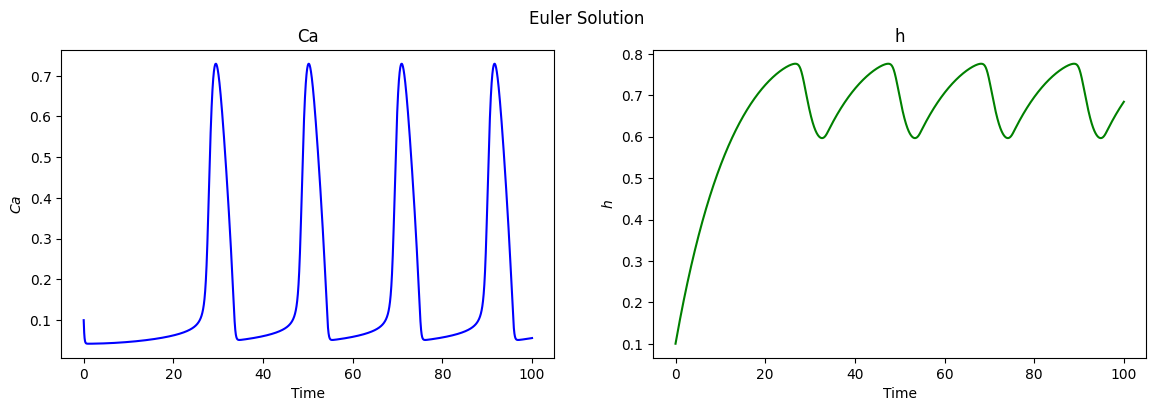

In [3]:
v2 = 0.1
a2 = 0.15
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [6]:
Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32, device=device)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32, device=device)[::100]

Training step: 0
Loss = 0.012779546901583672 | Physics_loss = 1.031231164932251| Initial_loss = 0.0 | Data_loss = 0.24672354757785797


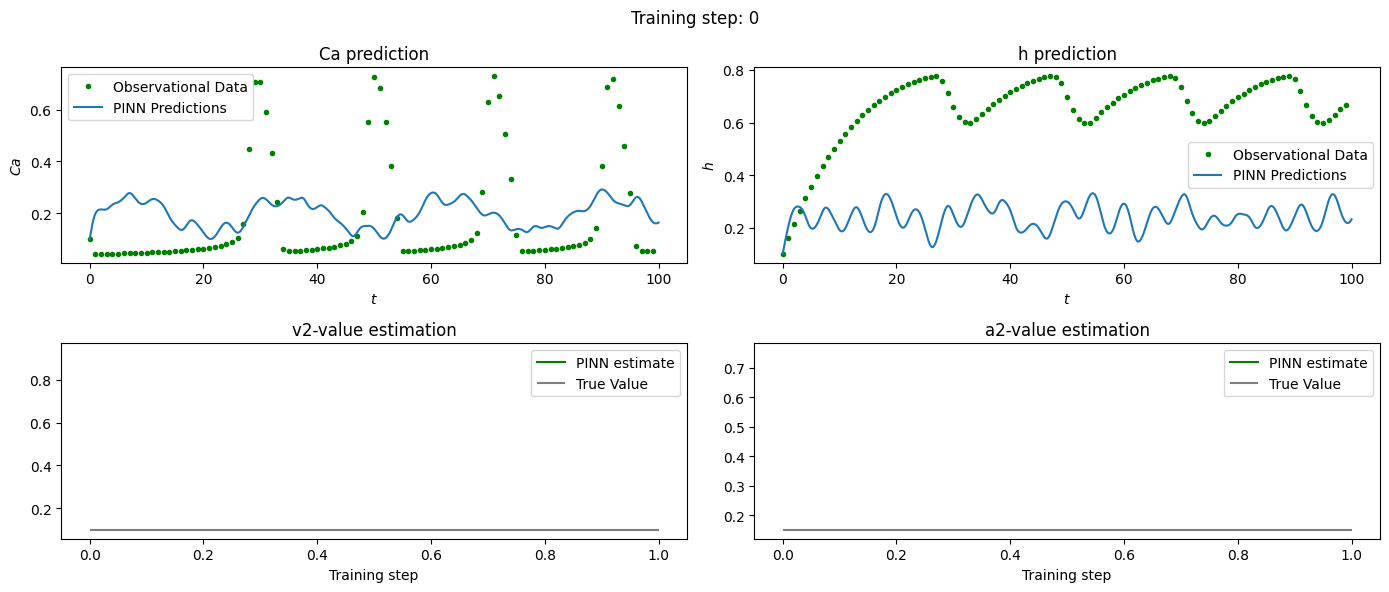

Training step: 1000
Loss = 0.0002571144141256809 | Physics_loss = 0.008144962601363659| Initial_loss = 0.0 | Data_loss = 0.017566479742527008


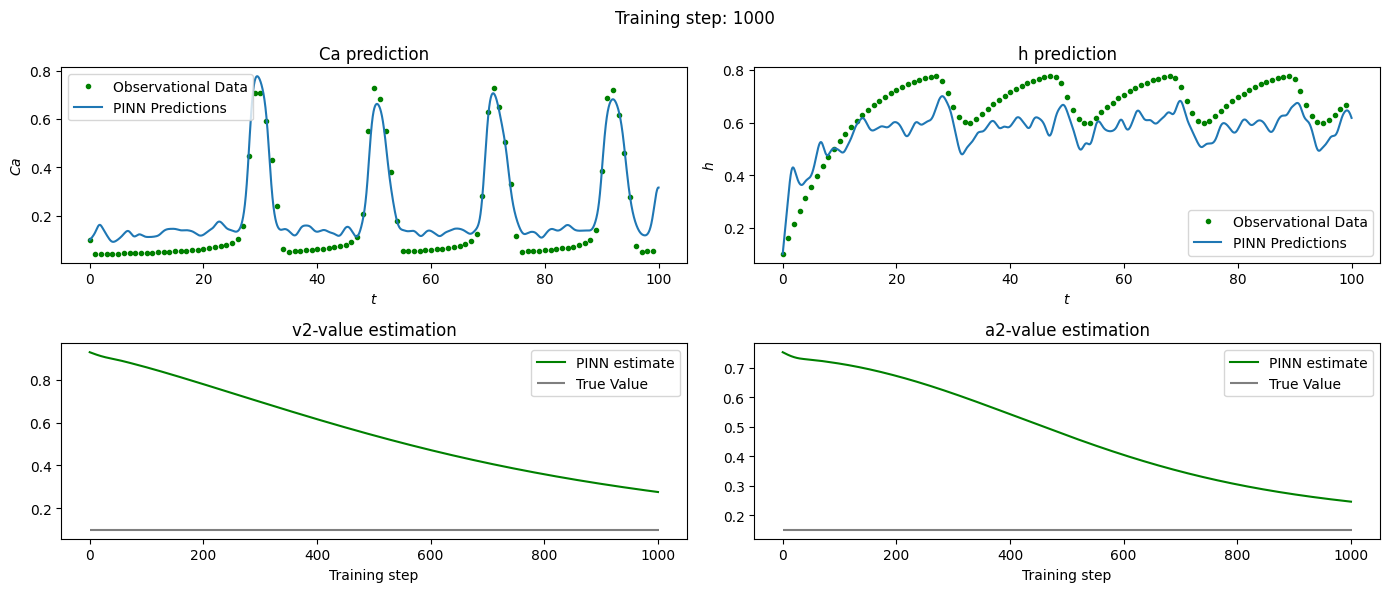

Training step: 2000
Loss = 1.9324428649269976e-05 | Physics_loss = 0.0009615373564884067| Initial_loss = 0.0 | Data_loss = 0.0009709055302664638


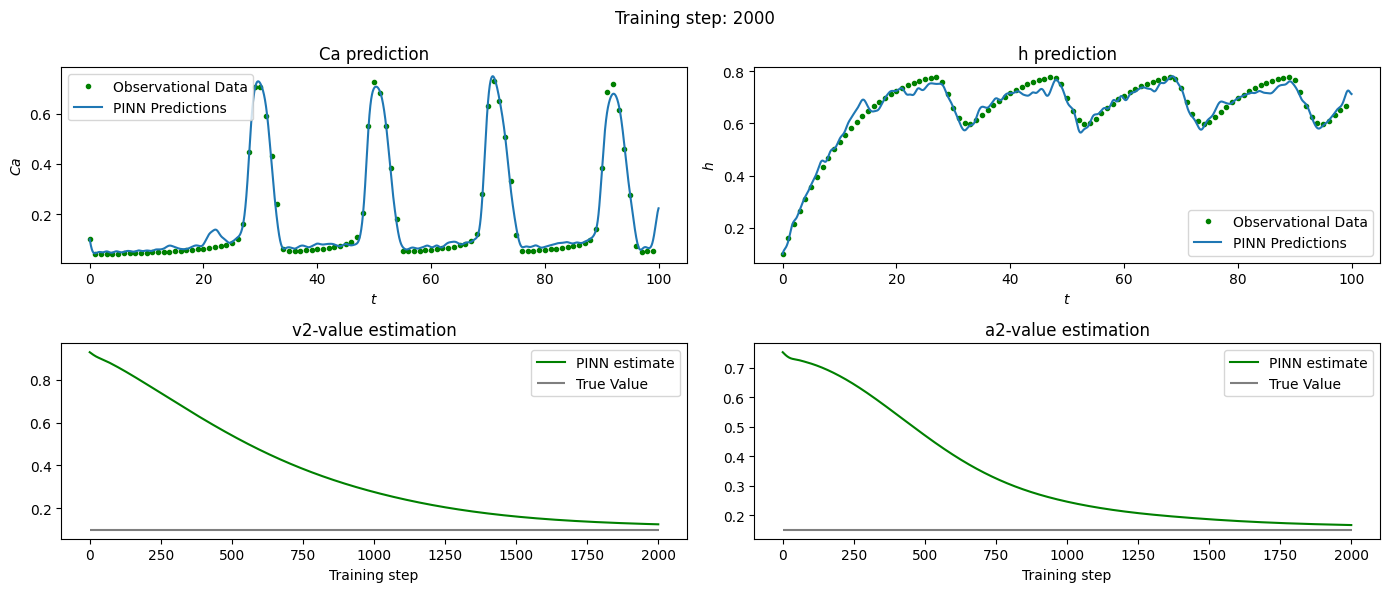

Training step: 3000
Loss = 8.58459225128172e-06 | Physics_loss = 0.0005775454919785261| Initial_loss = 0.0 | Data_loss = 0.00028091378044337034


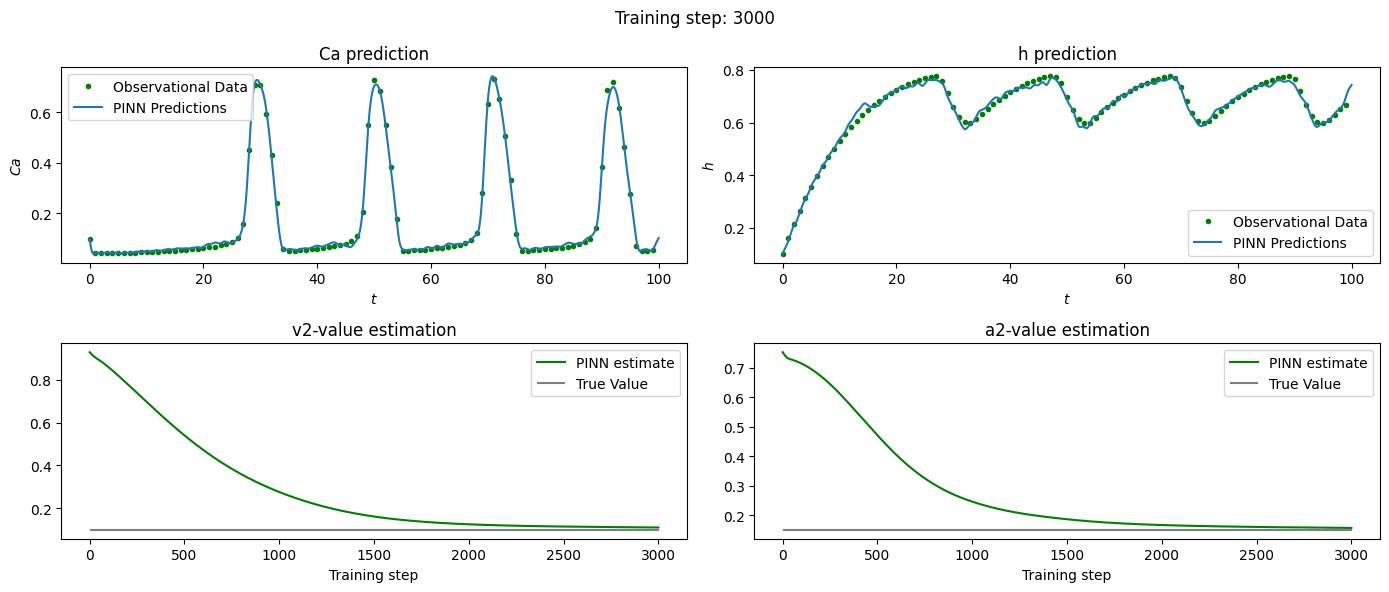

Training step: 4000
Loss = 3.893104803864844e-06 | Physics_loss = 0.00029049592558294535| Initial_loss = 0.0 | Data_loss = 9.881456207949668e-05


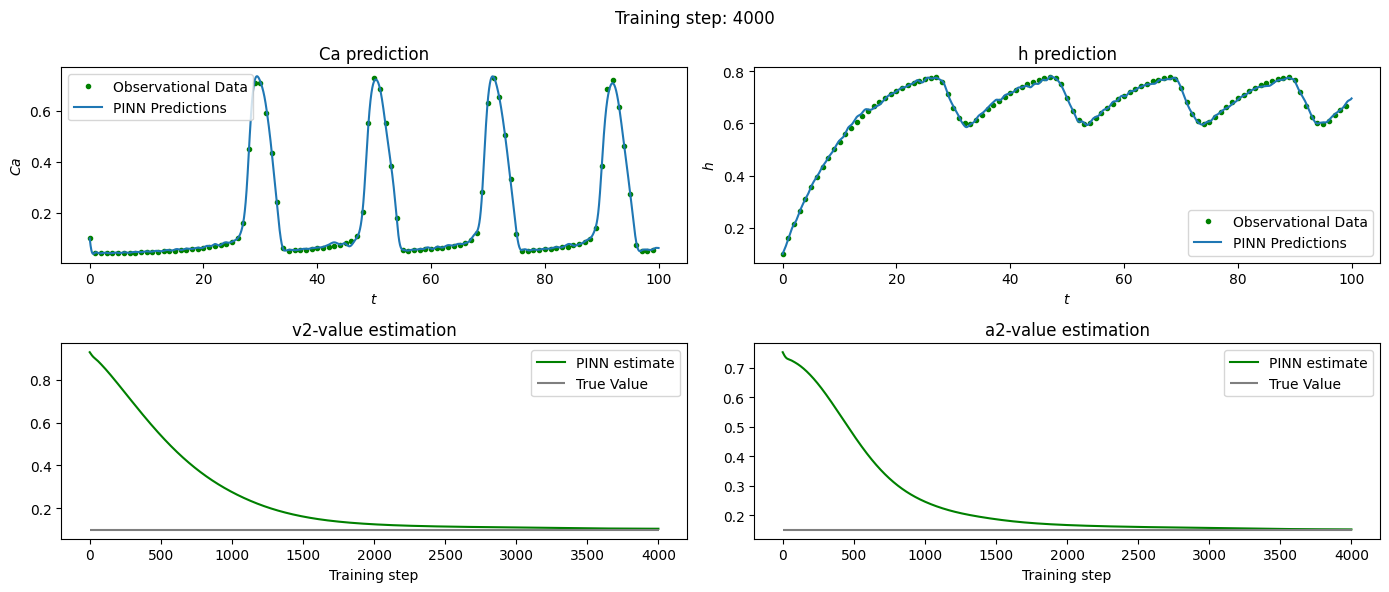

Training step: 5000
Loss = 2.4589153326814994e-06 | Physics_loss = 0.00019847348448820412| Initial_loss = 0.0 | Data_loss = 4.7418056055903435e-05


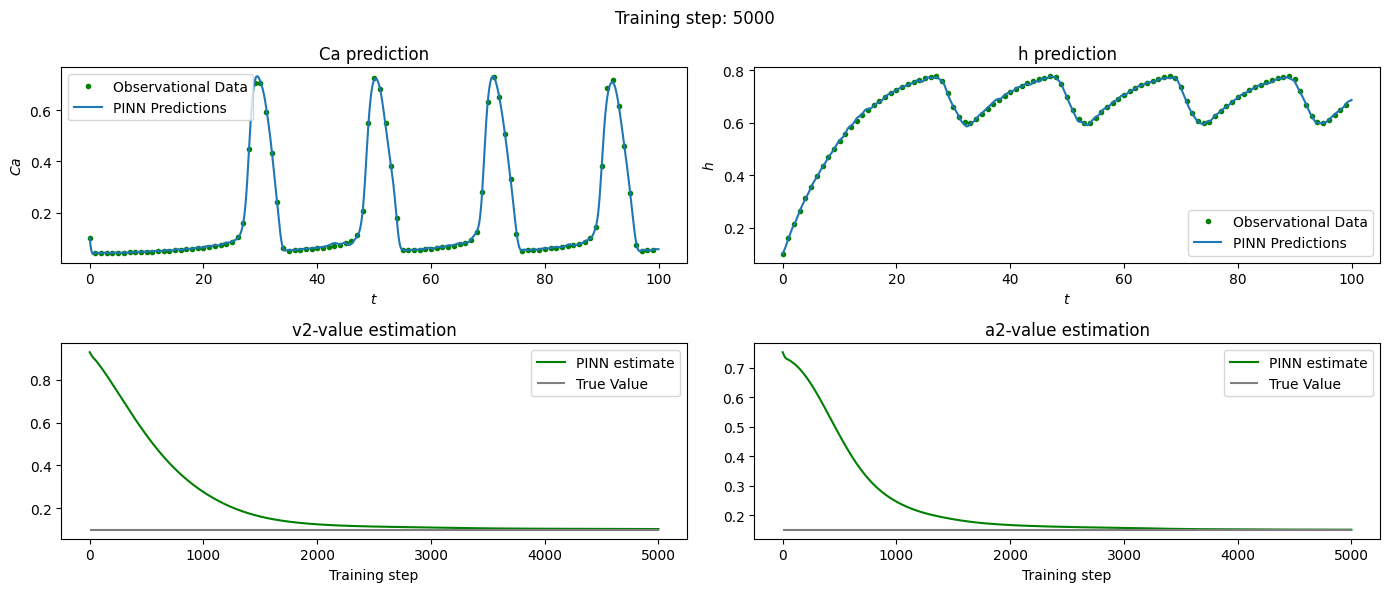

Training step: 6000
Loss = 1.8874740135288448e-06 | Physics_loss = 0.0001585213904036209| Initial_loss = 0.0 | Data_loss = 3.0226012313505635e-05


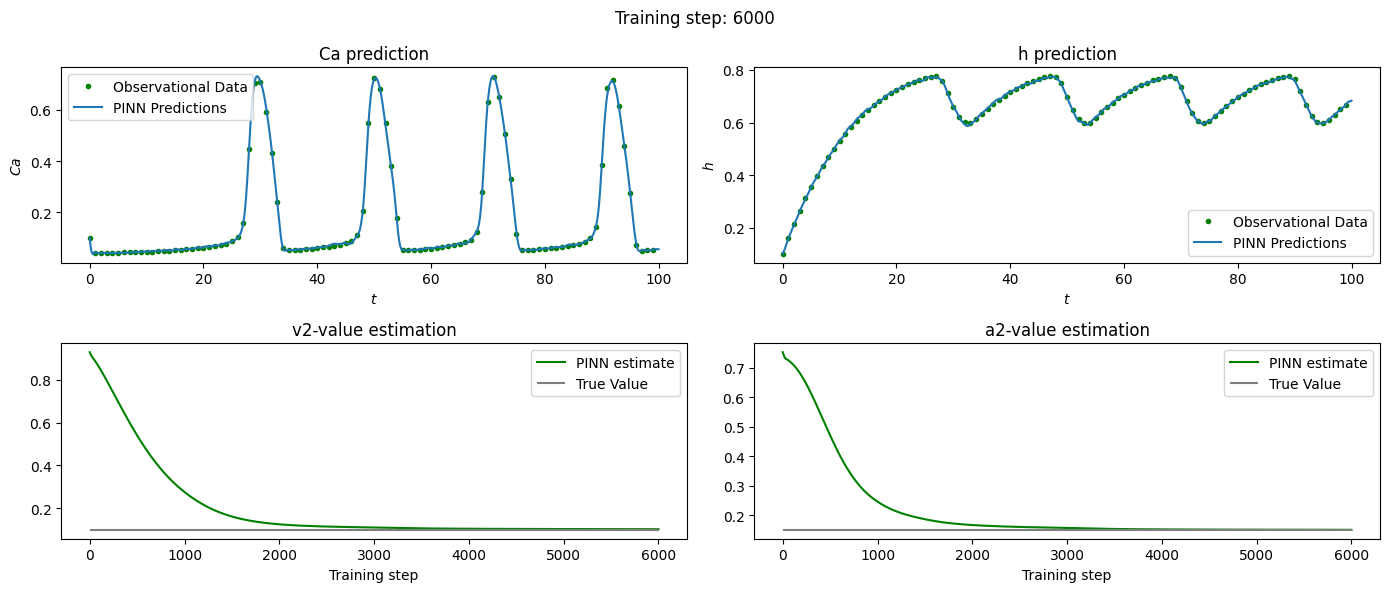

Training step: 7000
Loss = 3.1953286452335306e-06 | Physics_loss = 0.000283564324490726| Initial_loss = 0.0 | Data_loss = 3.596852911869064e-05


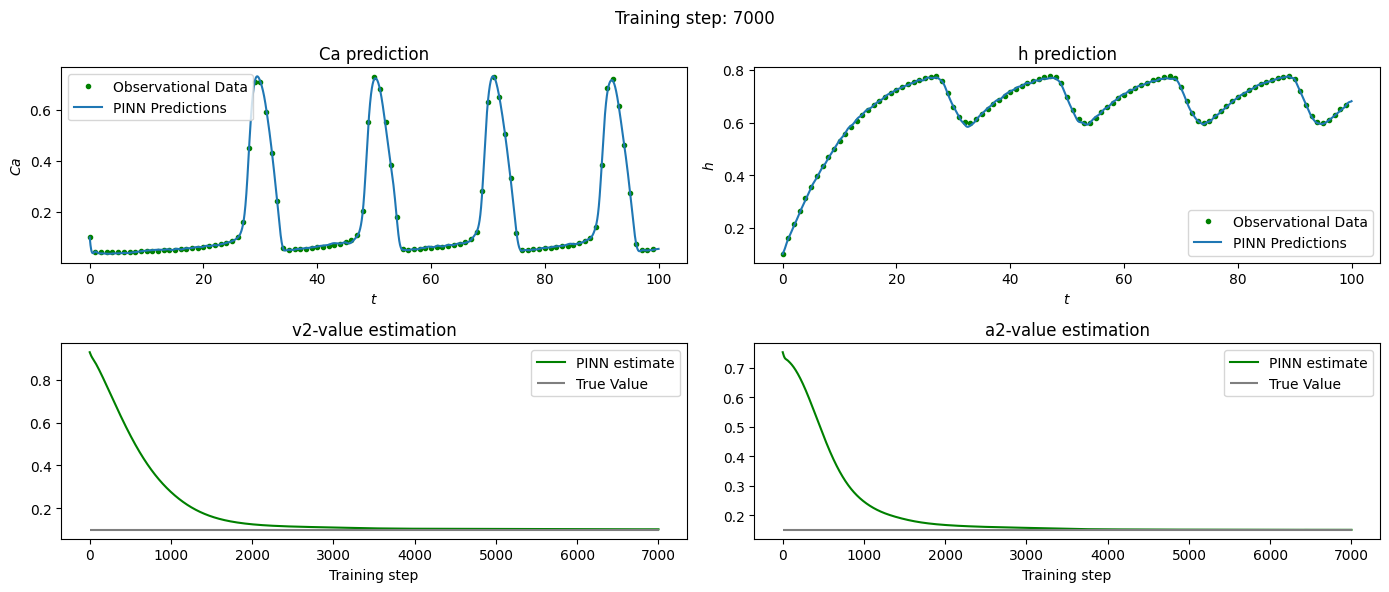

Training step: 8000
Loss = 1.5859324093980831e-06 | Physics_loss = 0.00013994566688779742| Initial_loss = 0.0 | Data_loss = 1.8647577235242352e-05


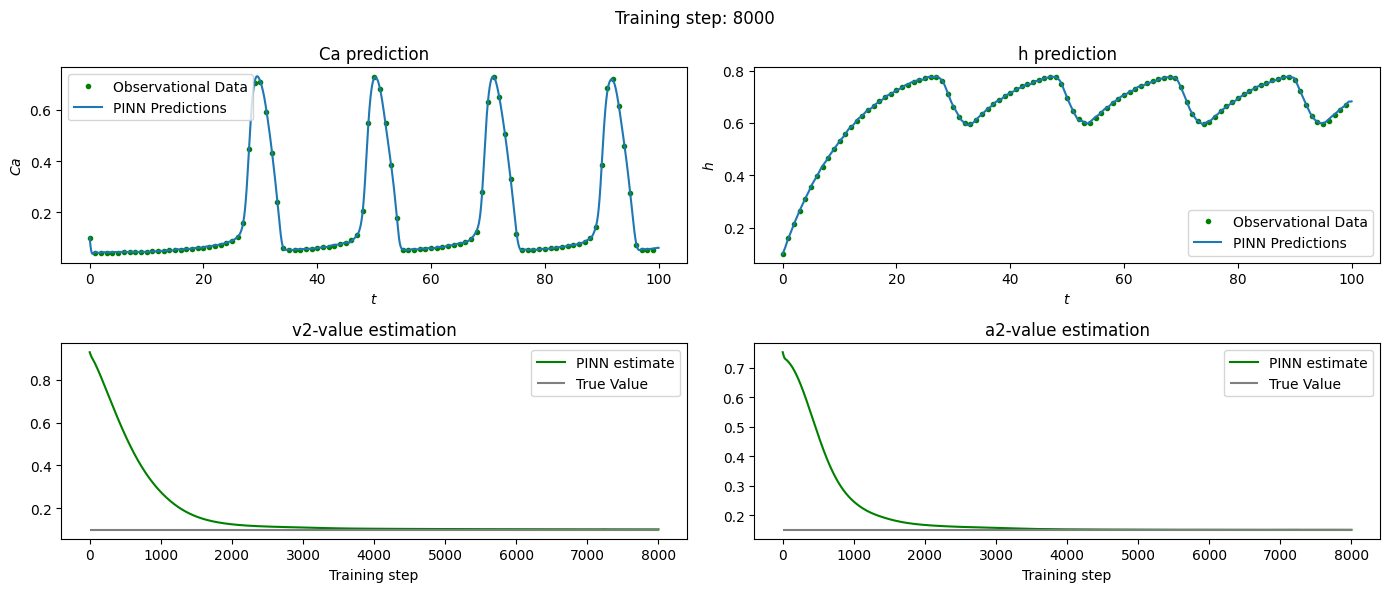

Training step: 9000
Loss = 1.1706828217938892e-06 | Physics_loss = 0.00010521786316530779| Initial_loss = 0.0 | Data_loss = 1.185041583084967e-05


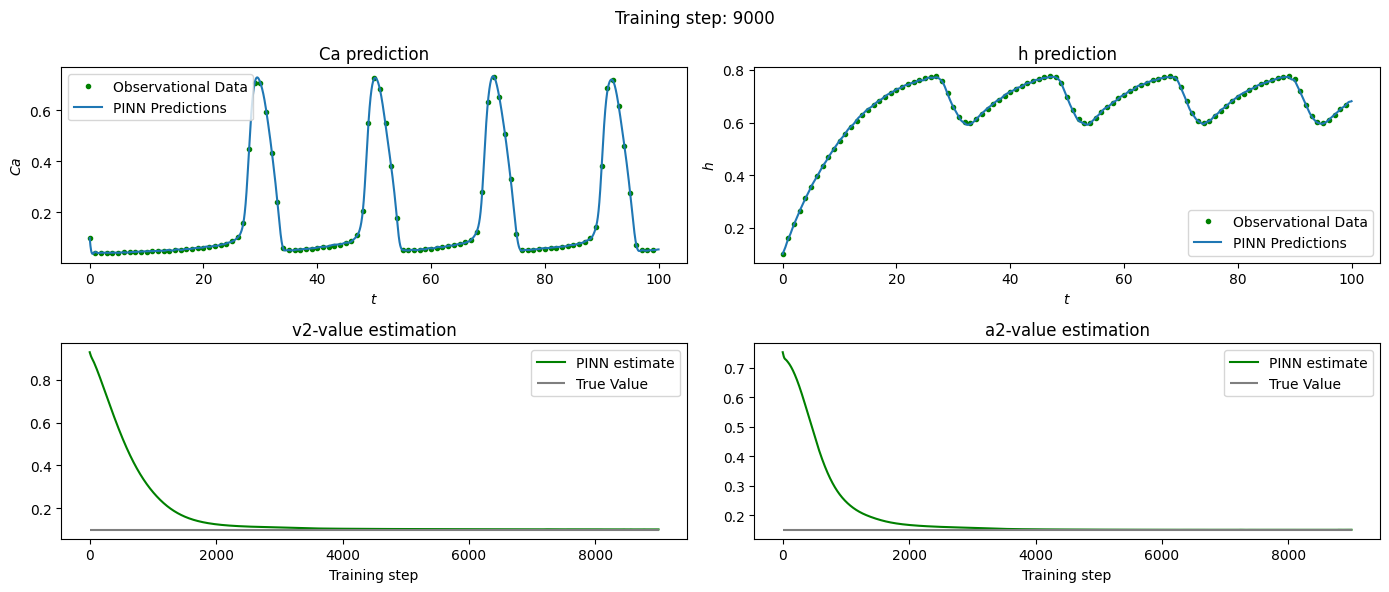

Training step: 10000
Loss = 8.269187219411833e-07 | Physics_loss = 7.553599425591528e-05| Initial_loss = 0.0 | Data_loss = 7.15587884769775e-06


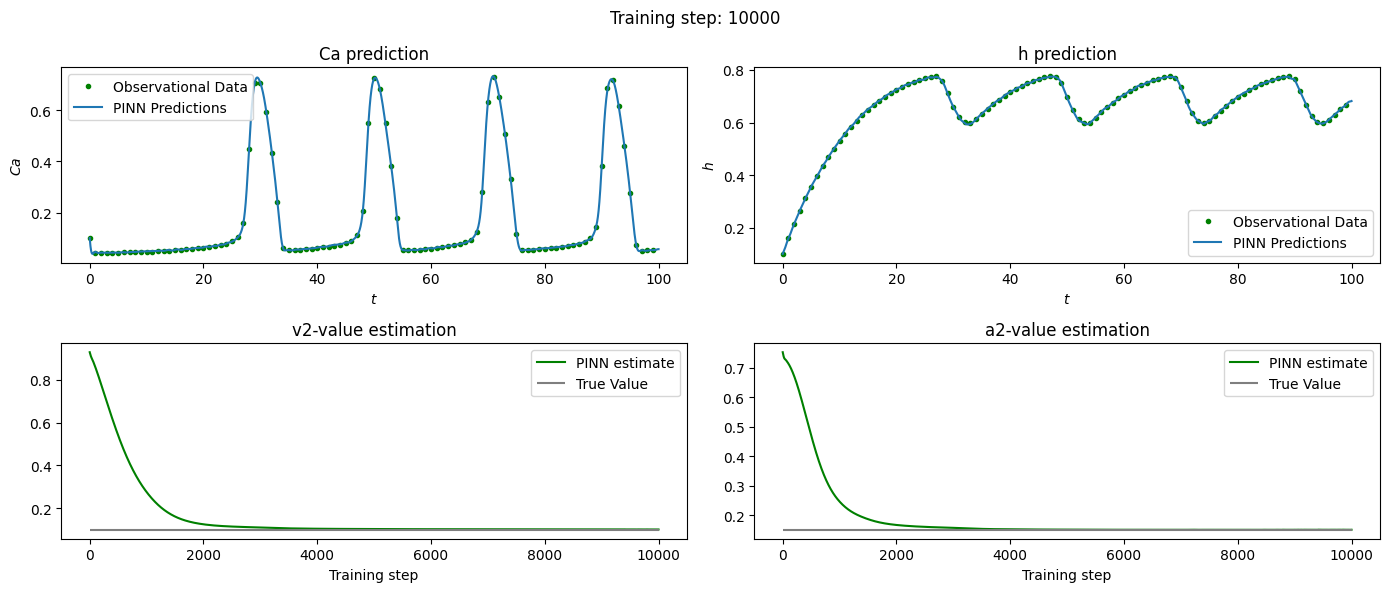

In [7]:
torch.manual_seed(2)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 100, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 100, 1.0).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1).to(device)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [33]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [34]:
from IPython.display import clear_output
from matplotlib import pyplot as plt


def live_plot(data, param_data, epoch, loss, data_loss, phy_loss):
    clear_output(wait=True)

    time, t_test, Ca_euler, Ca_pred, h_euler, h_pred = data
    v2s, v2_true, a2s, a2_true = param_data
    
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Epoch = {epoch} | Loss = {loss:.7f} | Data loss = {data_loss:.7f} | Physics loss = {phy_loss:.7f}")

    plt.subplot(221)
    plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
    plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
    plt.title("Ca prediction")
    plt.xlabel("$t$")
    plt.ylabel("$Ca$")
    plt.legend()

    plt.subplot(222)
    plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
    plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
    plt.title("h prediction")
    plt.xlabel("$t$")
    plt.ylabel("$h$")
    plt.legend()

    plt.subplot(223)
    plt.plot(v2s, label="PINN estimate", c='green')
    plt.hlines(v2_true, 0, len(v2s), color="tab:grey", label="True Value")
    plt.title("v2-value estimation")
    plt.xlabel("Training step")
    plt.legend(loc="upper right")

    plt.subplot(224)
    plt.plot(a2s, label="PINN estimate", c='green')
    plt.hlines(a2_true, 0, len(a2s), color="tab:grey", label="True Value")
    plt.title("a2-value estimation")
    plt.xlabel("Training step")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [35]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

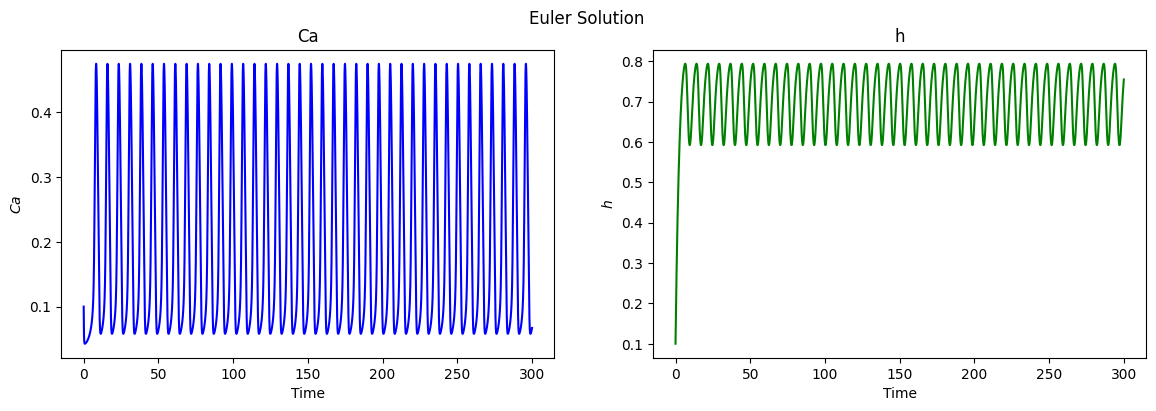

In [48]:
v2_true = 0.10
a2_true = 0.70
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 300, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2_true, a2_true, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [52]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.5
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

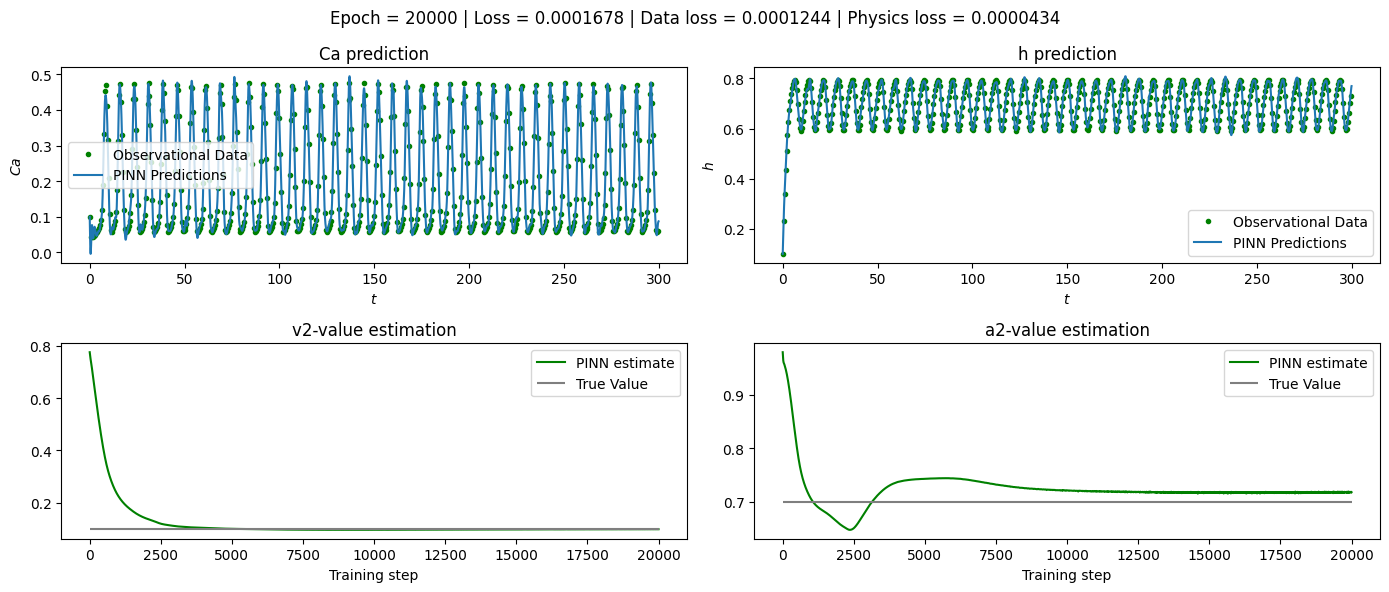

In [53]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::50]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::50]
t_test = torch.arange(0, 300, 0.01).view(-1, 1)
time = torch.arange(0, 300, 0.5).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.10
#a2 = 0.70

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  20001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
        
        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        d_loss = loss1 + loss2
        p_loss = loss5 + loss6
        t_loss = loss1+ loss2 + loss5 + loss6

        live_plot((time, t_test, Ca_euler, Ca_pred, h_euler, h_pred), (v2s, v2_true, a2s, a2_true), i, t_loss, d_loss, p_loss)
        

In [54]:
v2s[-1], a2s[-1]

(0.0993531122803688, 0.7176494002342224)

In [153]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [154]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

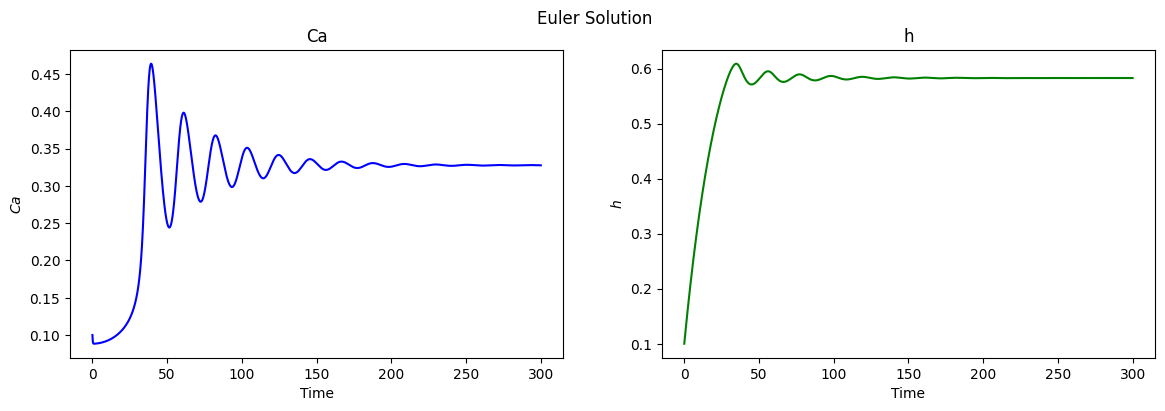

In [155]:
v2 = 0.26
a2 = 0.07
IP3 = 0.5
d5 = 0.10
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 300, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 0.1
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [11]:
Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32, device=device)[::20]
h_euler = torch.tensor(h_euler1, dtype=torch.float32, device=device)[::20]

Training step: 0
Loss = 0.06084437668323517 | Physics_loss = 0.5925499796867371| Initial_loss = 0.0 | Data_loss = 0.15893769264221191


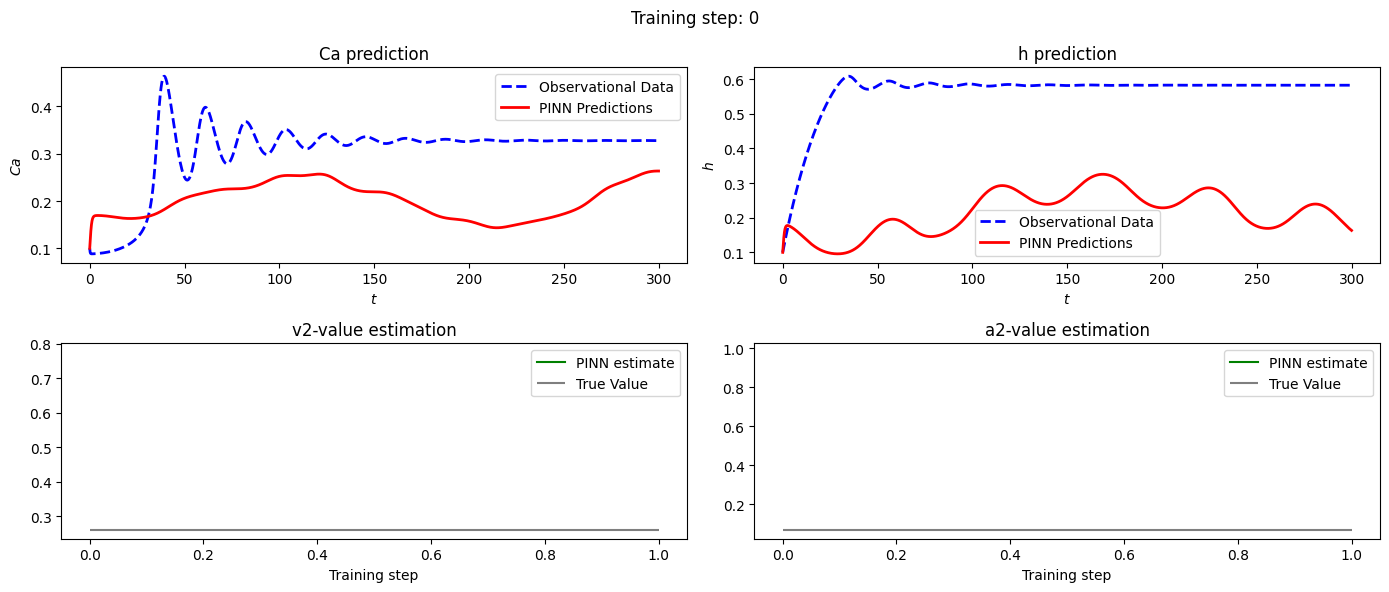

Training step: 1000
Loss = 0.0007268433109857142 | Physics_loss = 0.0008734182920306921| Initial_loss = 0.0 | Data_loss = 0.06395015120506287


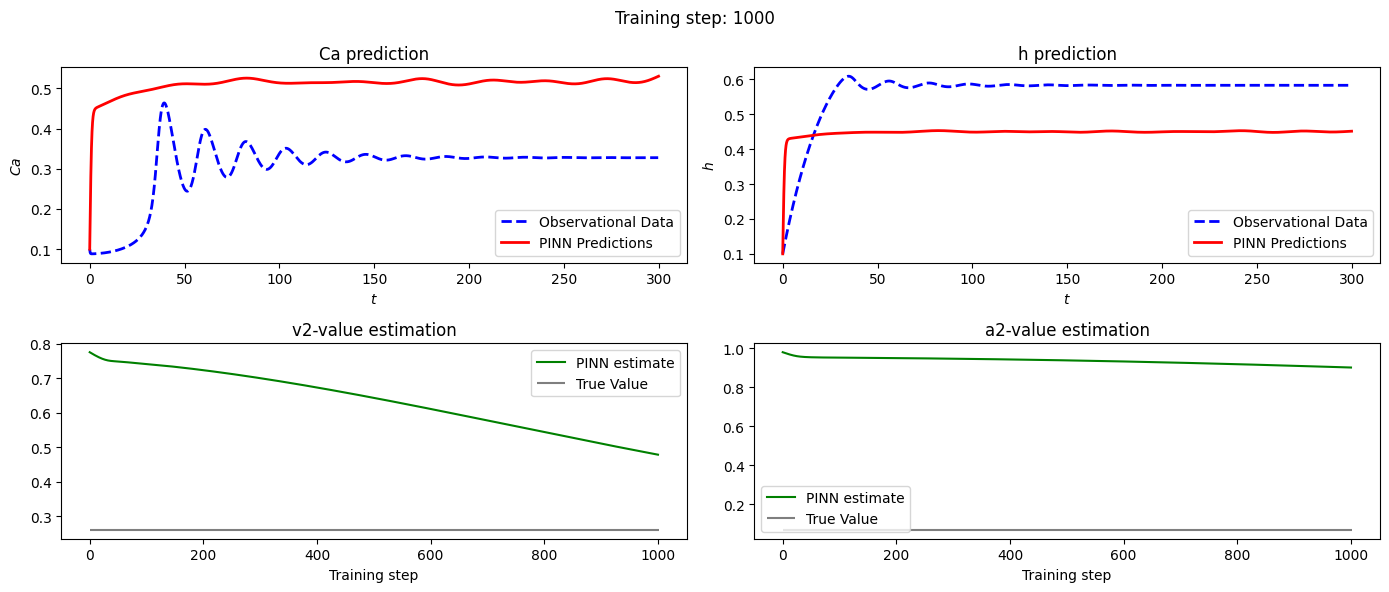

Training step: 2000
Loss = 0.00012750398309435695 | Physics_loss = 0.00043923233170062304| Initial_loss = 0.0 | Data_loss = 0.008358074352145195


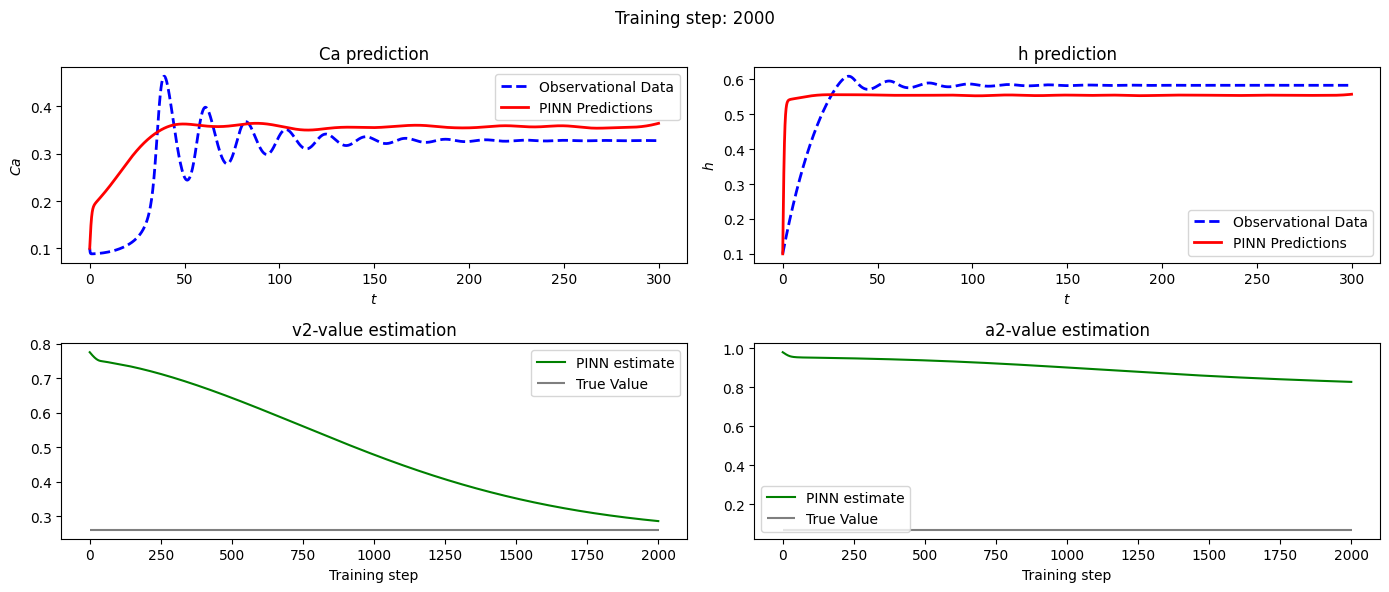

Training step: 3000
Loss = 0.00010928984556812793 | Physics_loss = 0.00045138769201003015| Initial_loss = 0.0 | Data_loss = 0.006415107287466526


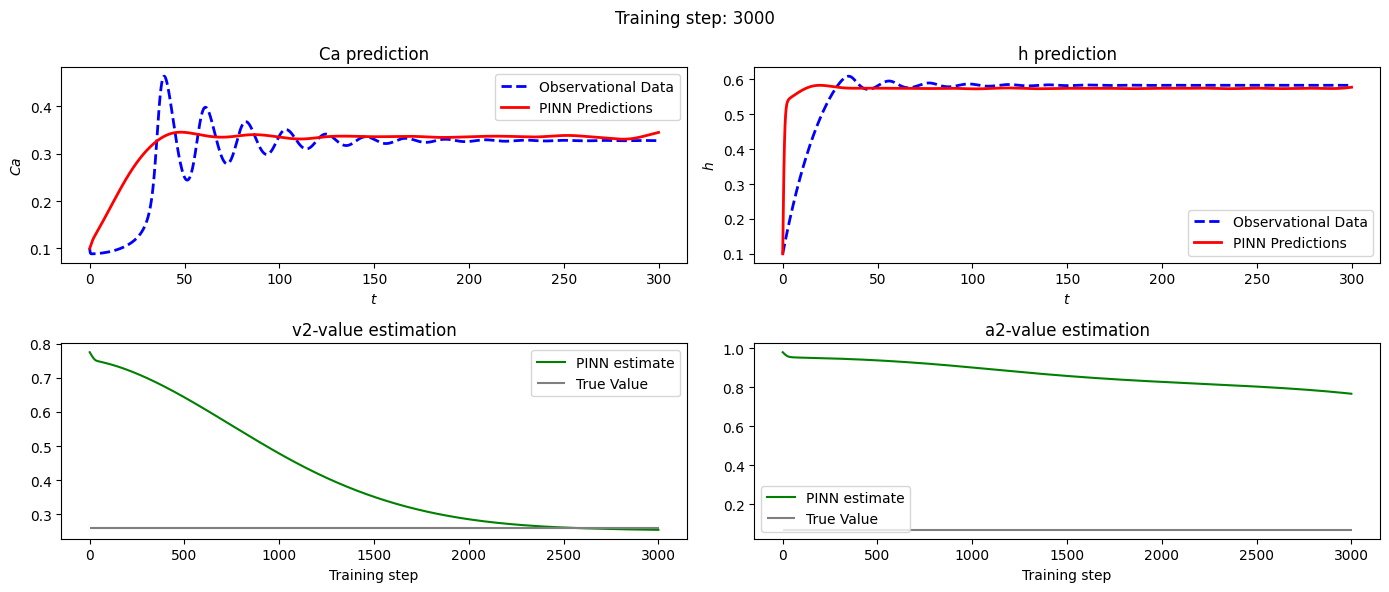

Training step: 4000
Loss = 8.402482490055263e-05 | Physics_loss = 0.0003360989212524146| Initial_loss = 0.0 | Data_loss = 0.0050414931029081345


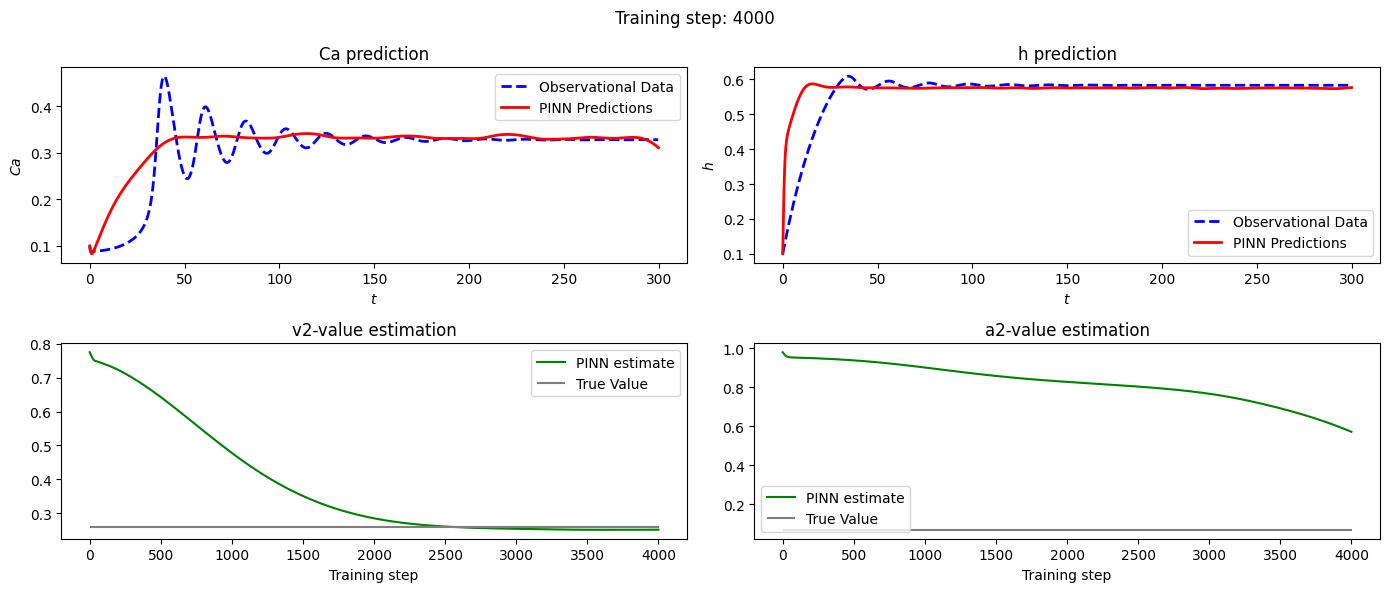

Training step: 5000
Loss = 1.809643072192557e-05 | Physics_loss = 4.113855538889766e-05| Initial_loss = 0.0 | Data_loss = 0.0013982575619593263


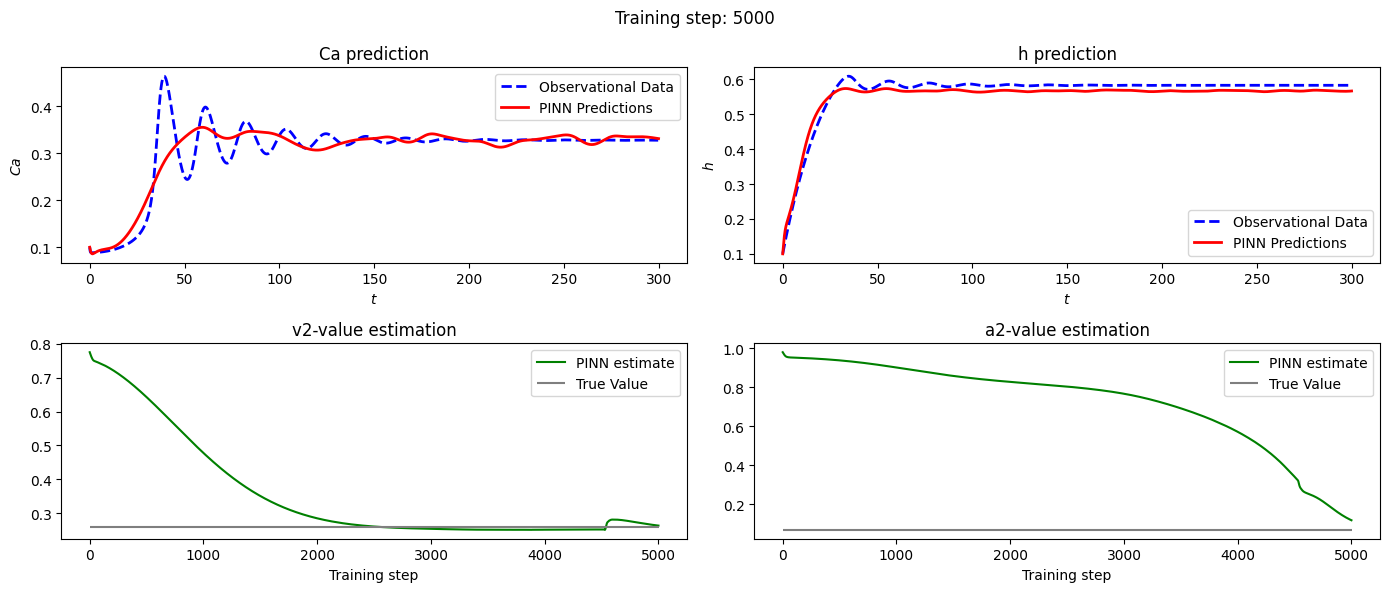

Training step: 6000
Loss = 1.2526565114967525e-05 | Physics_loss = 2.2383408577297814e-05| Initial_loss = 0.0 | Data_loss = 0.0010288223857060075


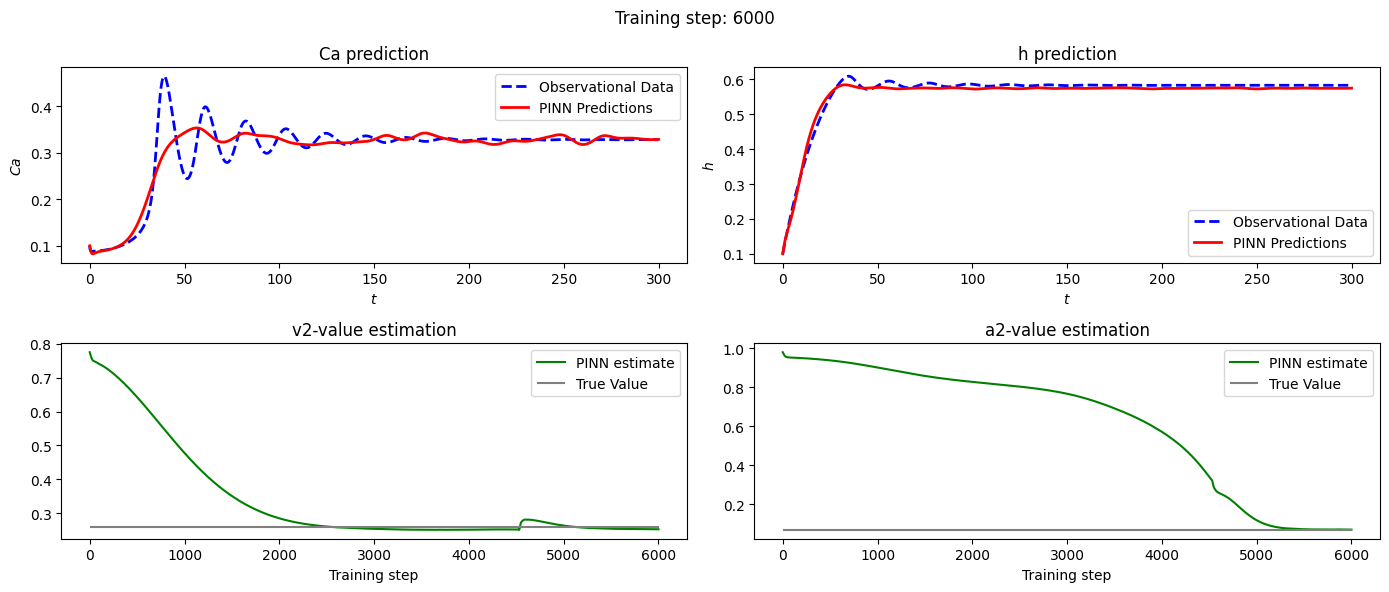

Training step: 7000
Loss = 1.0314575774827972e-05 | Physics_loss = 2.1344701963244006e-05| Initial_loss = 0.0 | Data_loss = 0.0008180105942301452


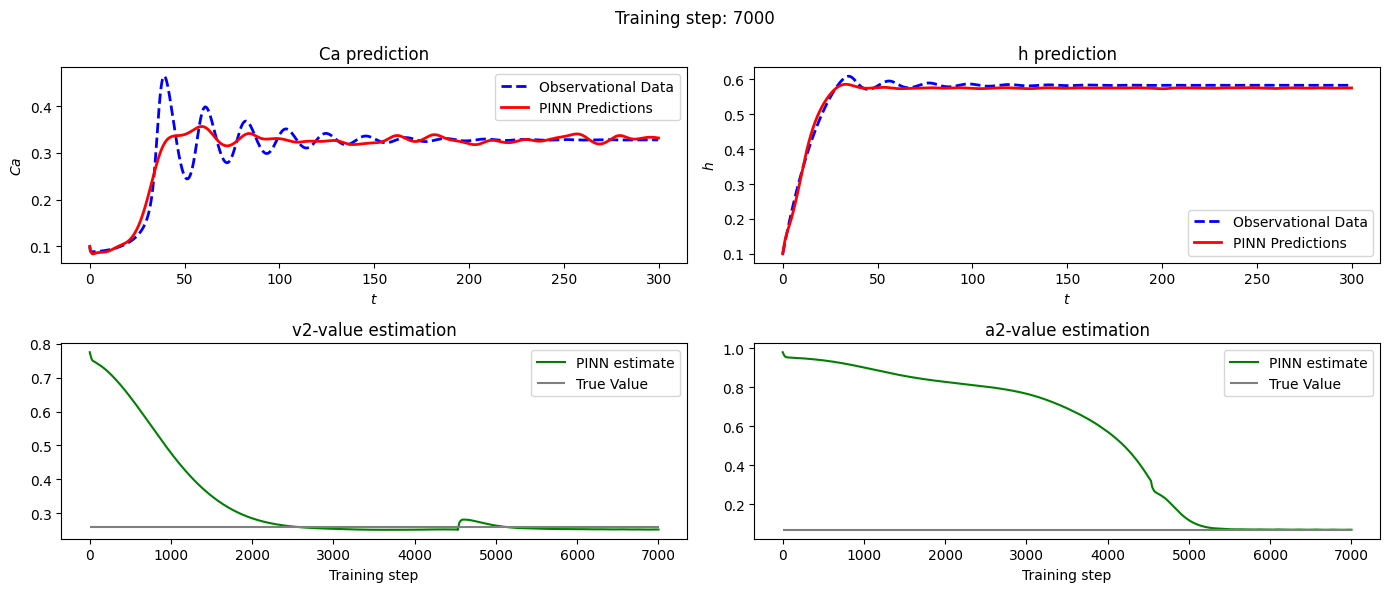

Training step: 8000
Loss = 7.671720595681109e-06 | Physics_loss = 3.558626485755667e-05| Initial_loss = 0.0 | Data_loss = 0.0004113094473723322


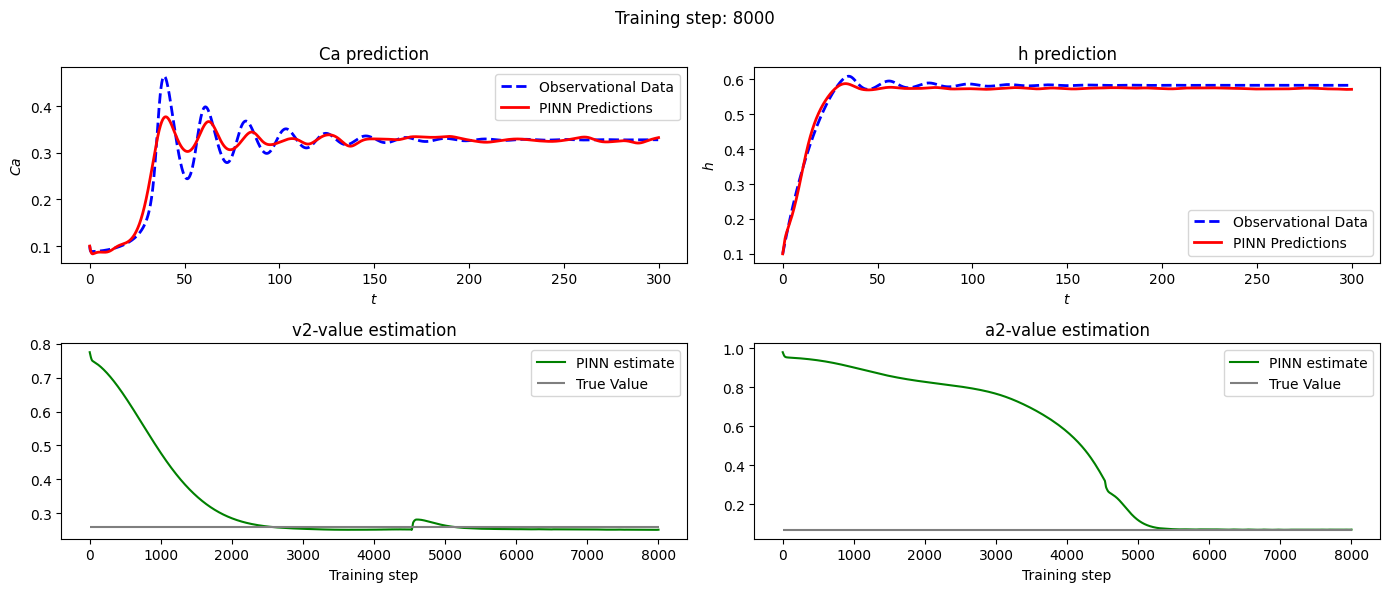

Training step: 9000
Loss = 4.161085598752834e-06 | Physics_loss = 2.2296679162536748e-05| Initial_loss = 0.0 | Data_loss = 0.0001931418082676828


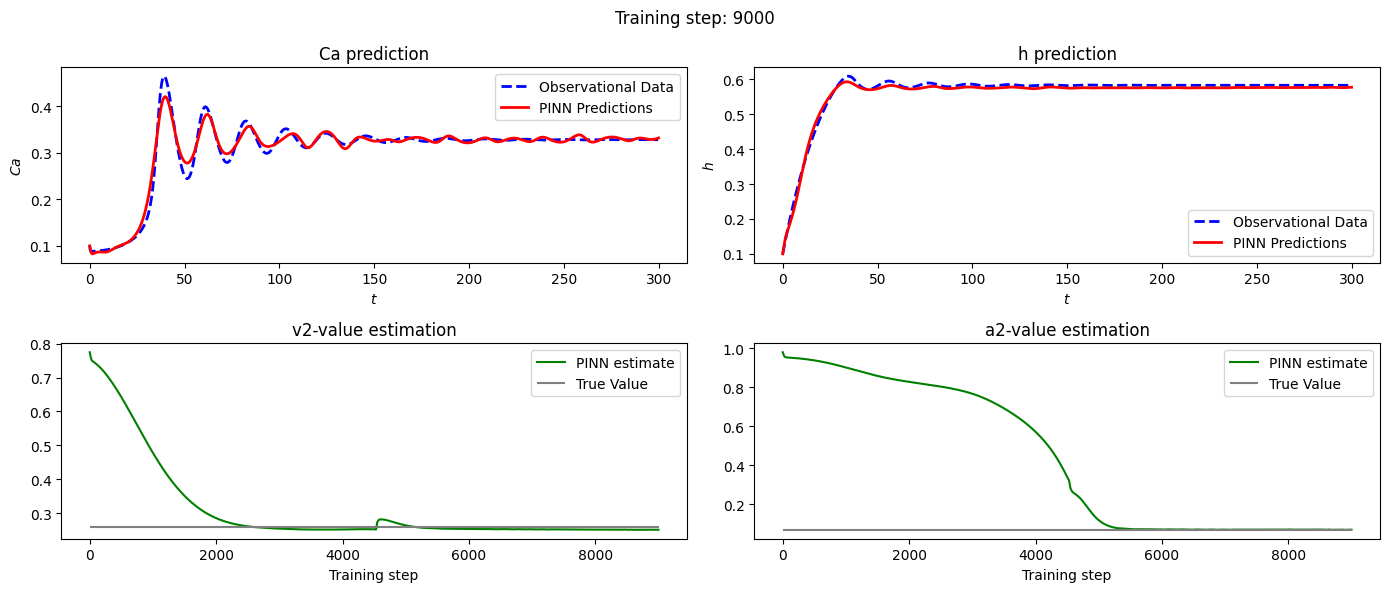

Training step: 10000
Loss = 3.1434524316864554e-06 | Physics_loss = 2.1132220354047604e-05| Initial_loss = 0.0 | Data_loss = 0.00010302303417120129


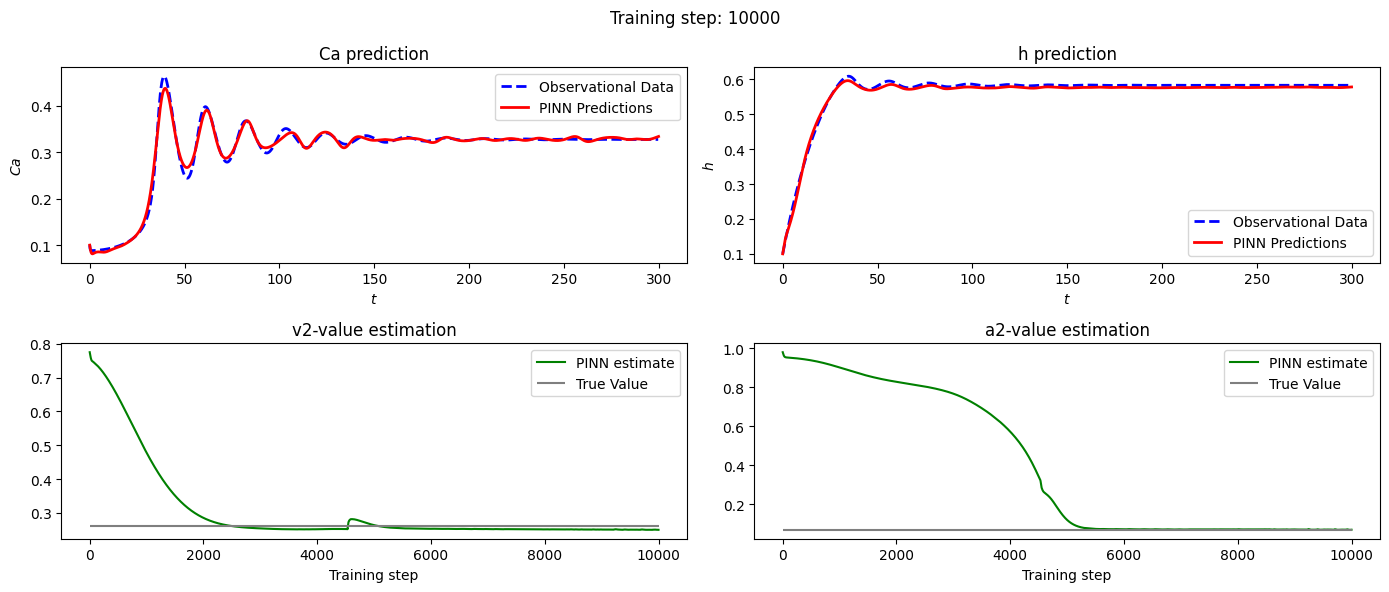

Training step: 11000
Loss = 2.3948050511535257e-06 | Physics_loss = 1.7218371795024723e-05| Initial_loss = 0.0 | Data_loss = 6.729678716510534e-05


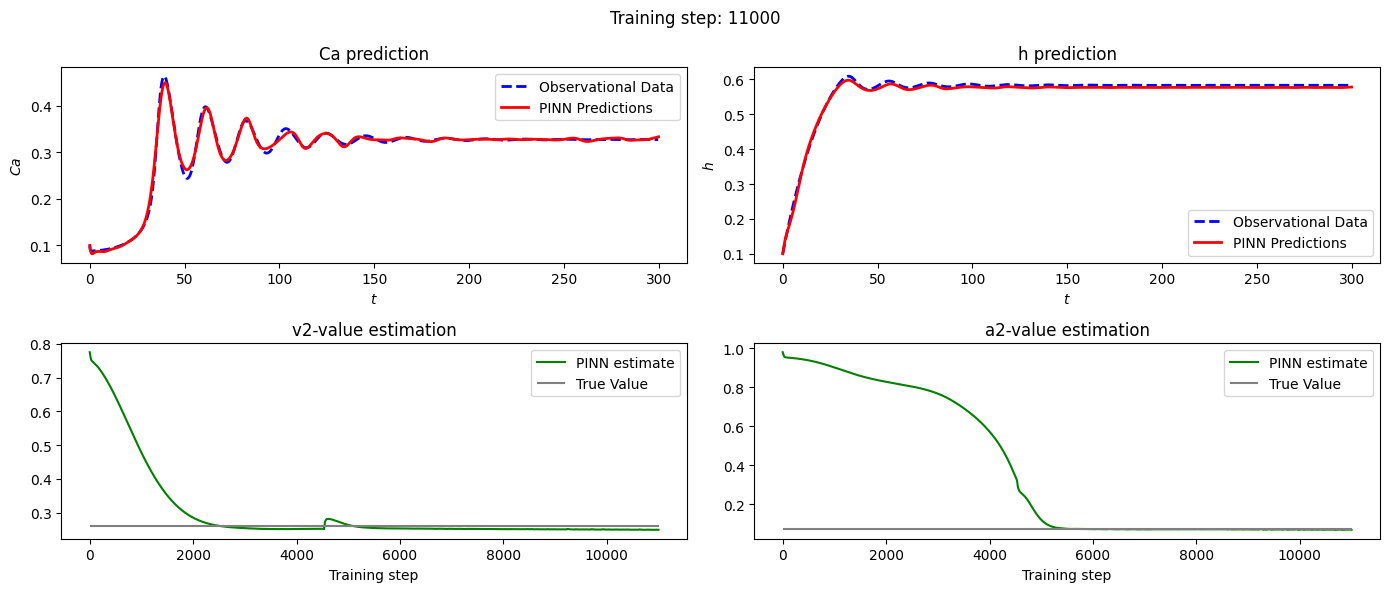

Training step: 12000
Loss = 2.2861258912598714e-06 | Physics_loss = 1.71791161847068e-05| Initial_loss = 0.0 | Data_loss = 5.682142364094034e-05


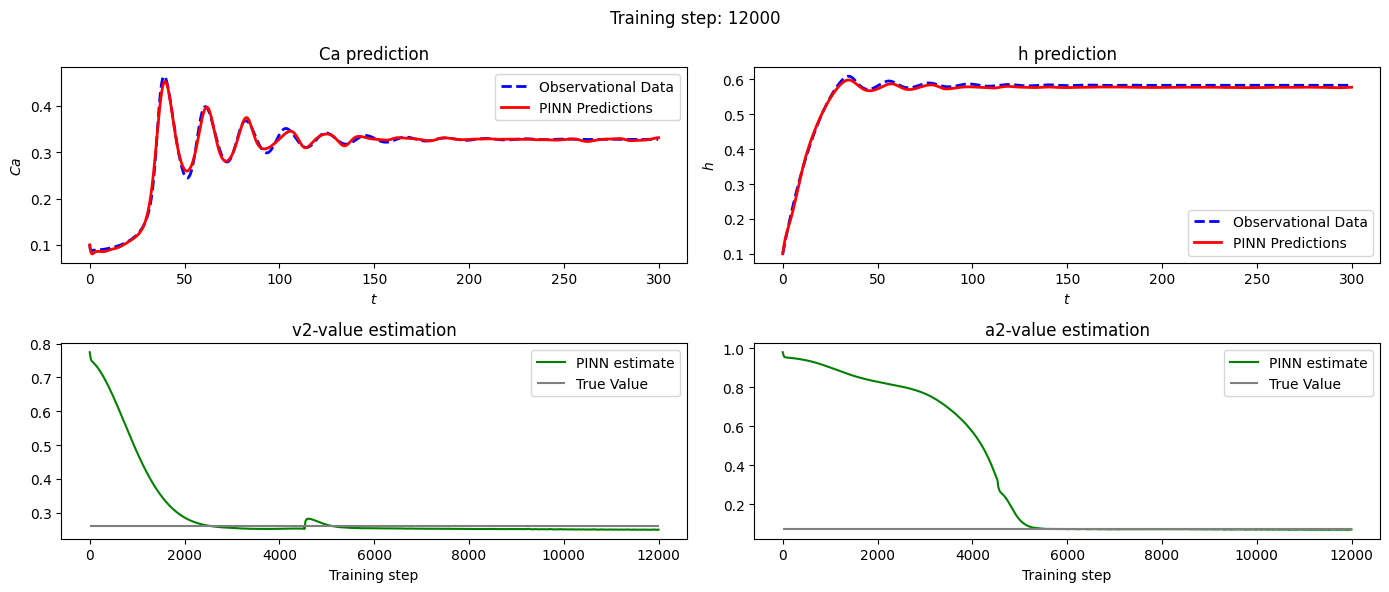

Training step: 13000
Loss = 2.0828324522881303e-06 | Physics_loss = 1.571139000589028e-05| Initial_loss = 0.0 | Data_loss = 5.1169343350920826e-05


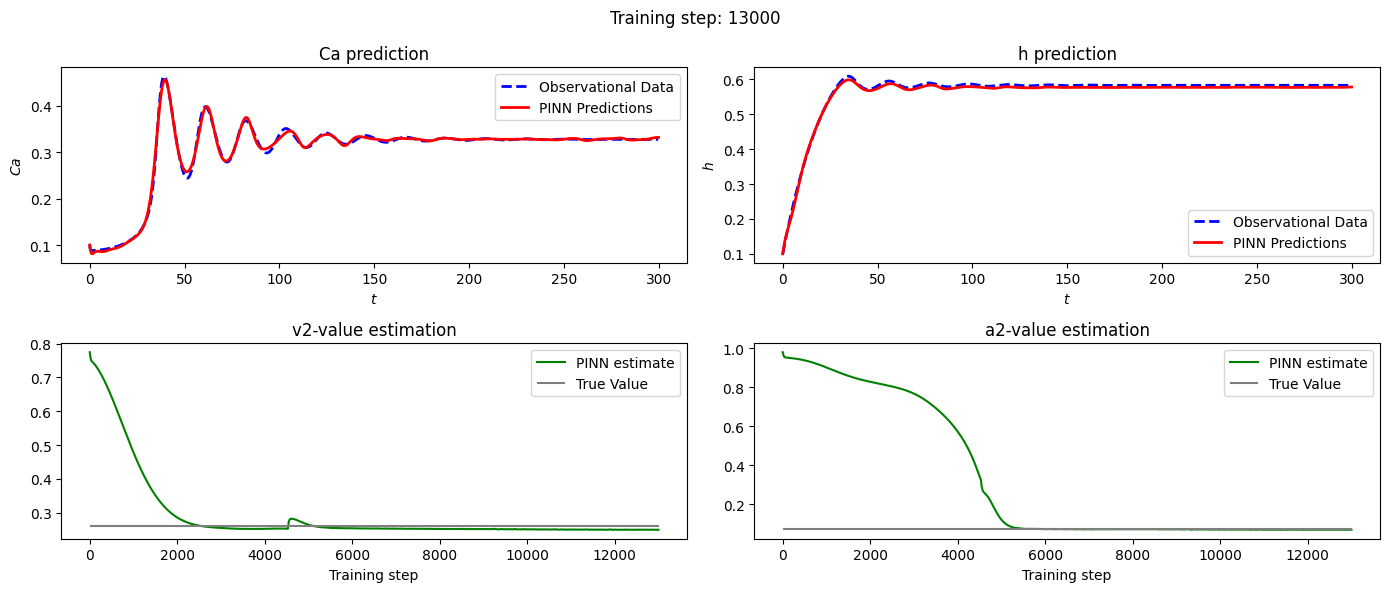

Training step: 14000
Loss = 2.2763524611946195e-06 | Physics_loss = 1.7801710782805458e-05| Initial_loss = 0.0 | Data_loss = 4.961813101544976e-05


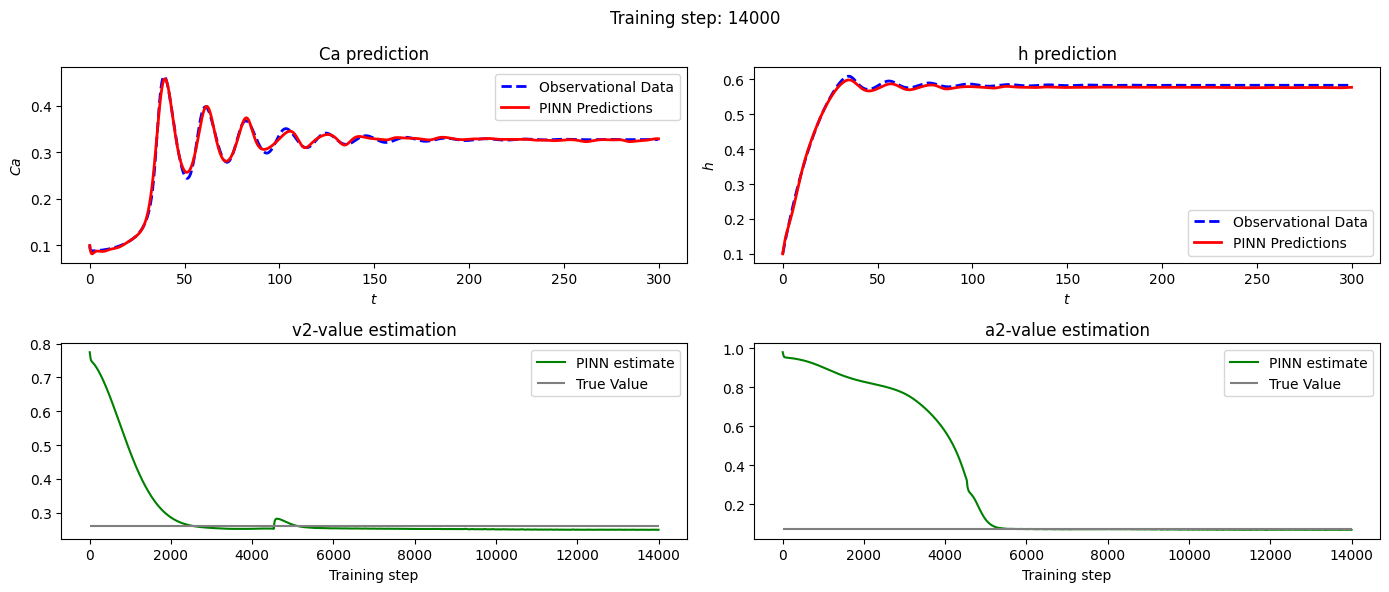

Training step: 15000
Loss = 4.5233000491862185e-06 | Physics_loss = 4.108643770450726e-05| Initial_loss = 0.0 | Data_loss = 4.146563878748566e-05


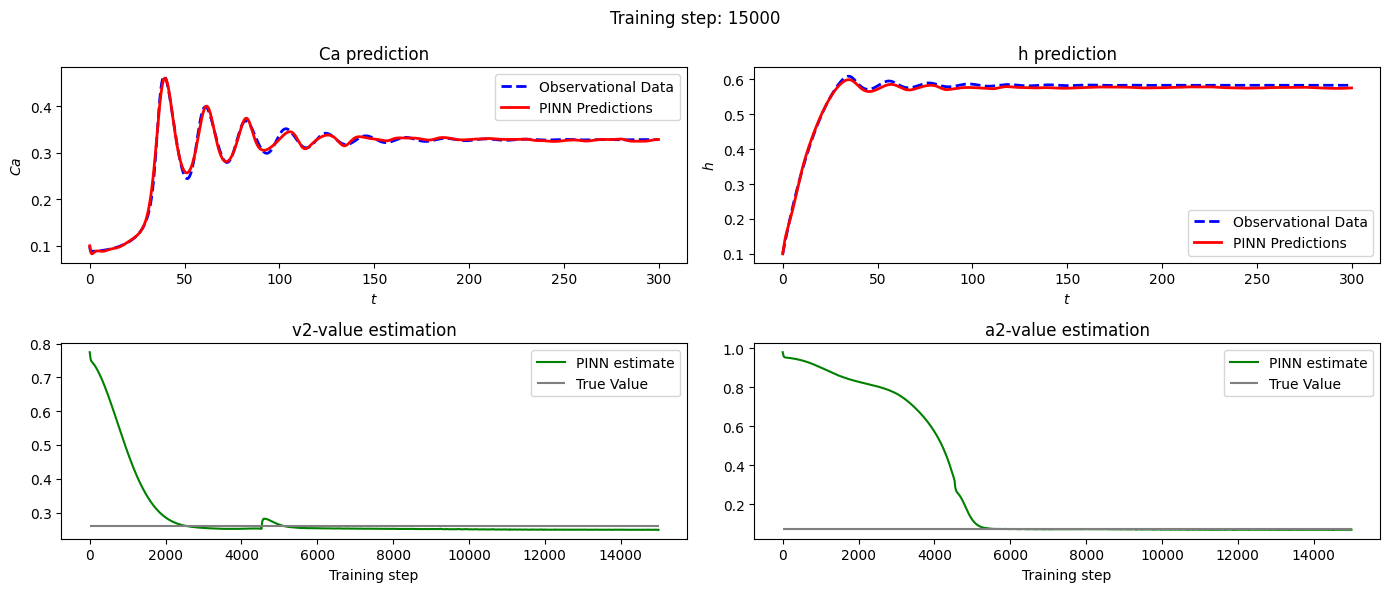

Training step: 16000
Loss = 1.957592530743568e-06 | Physics_loss = 1.5300563973141834e-05| Initial_loss = 0.0 | Data_loss = 4.2753610614454374e-05


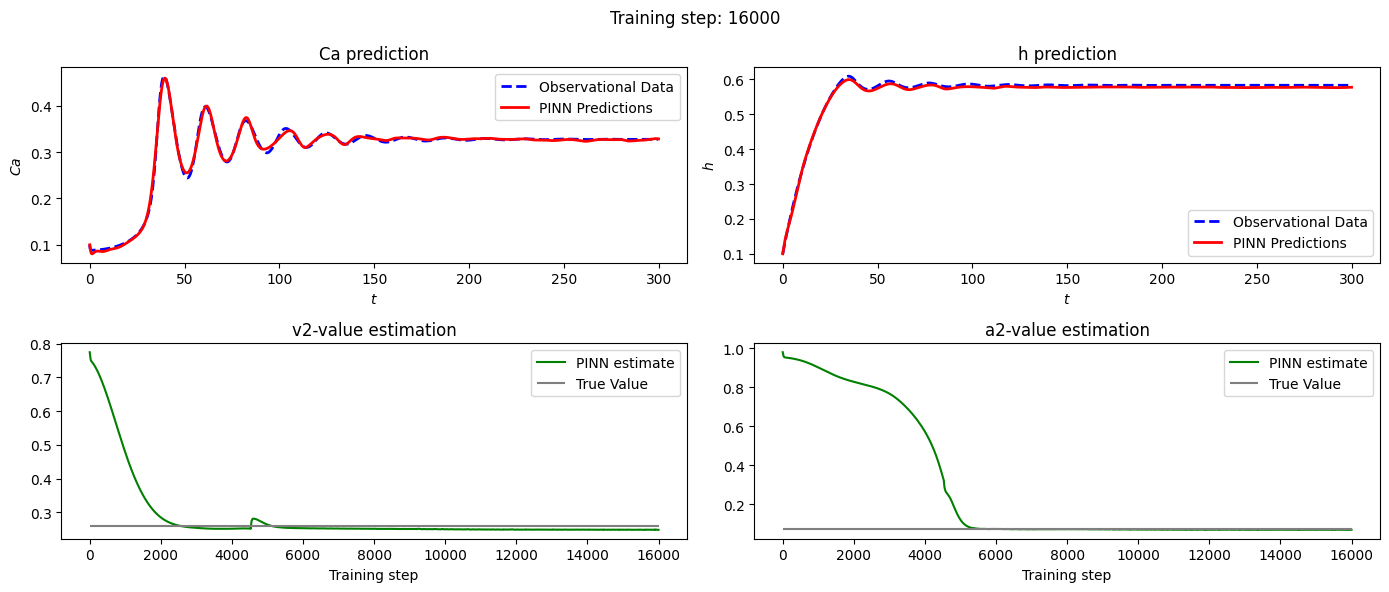

Training step: 17000
Loss = 2.0761794985446613e-06 | Physics_loss = 1.5826512026251294e-05| Initial_loss = 0.0 | Data_loss = 4.935282777296379e-05


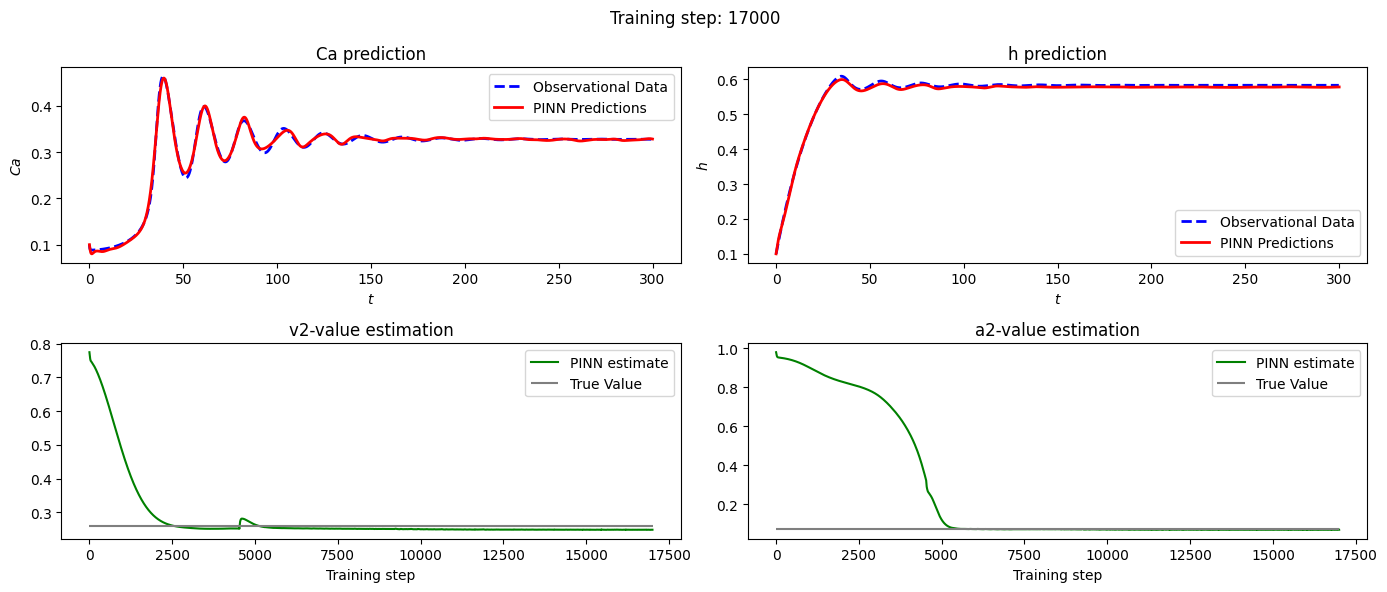

Training step: 18000
Loss = 1.8281738221048727e-06 | Physics_loss = 1.388716100336751e-05| Initial_loss = 0.0 | Data_loss = 4.394577263155952e-05


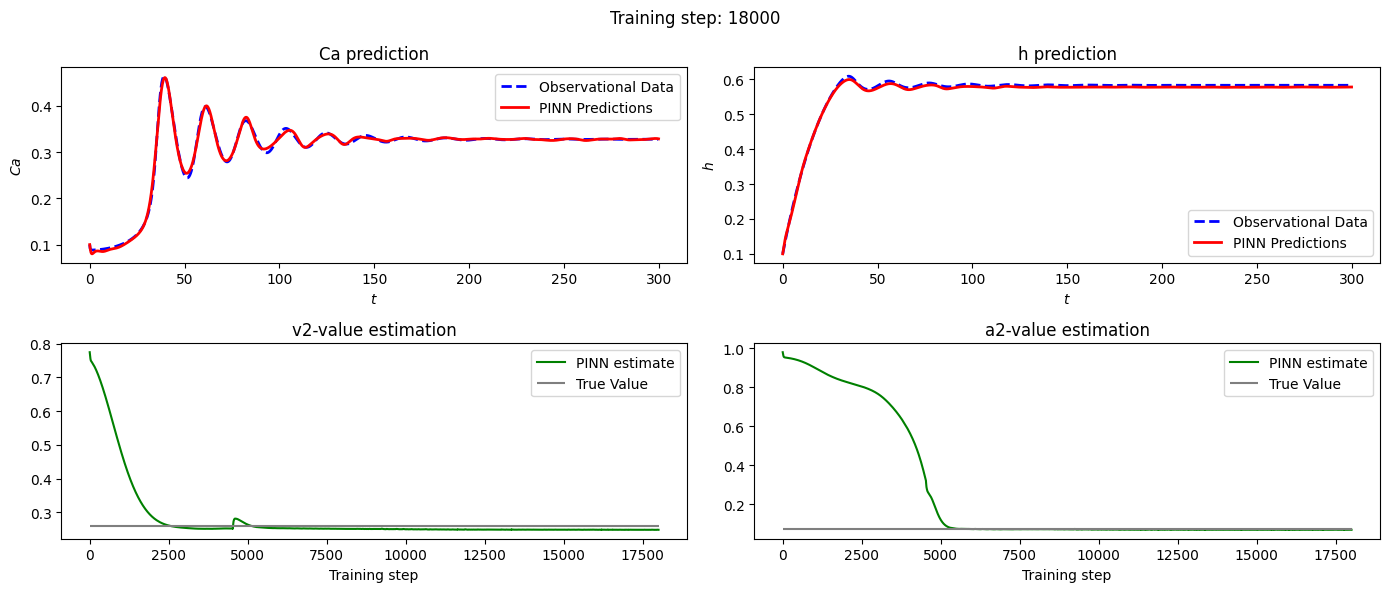

Training step: 19000
Loss = 3.1960832984623266e-06 | Physics_loss = 2.8245895009604283e-05| Initial_loss = 0.0 | Data_loss = 3.7149373383726925e-05


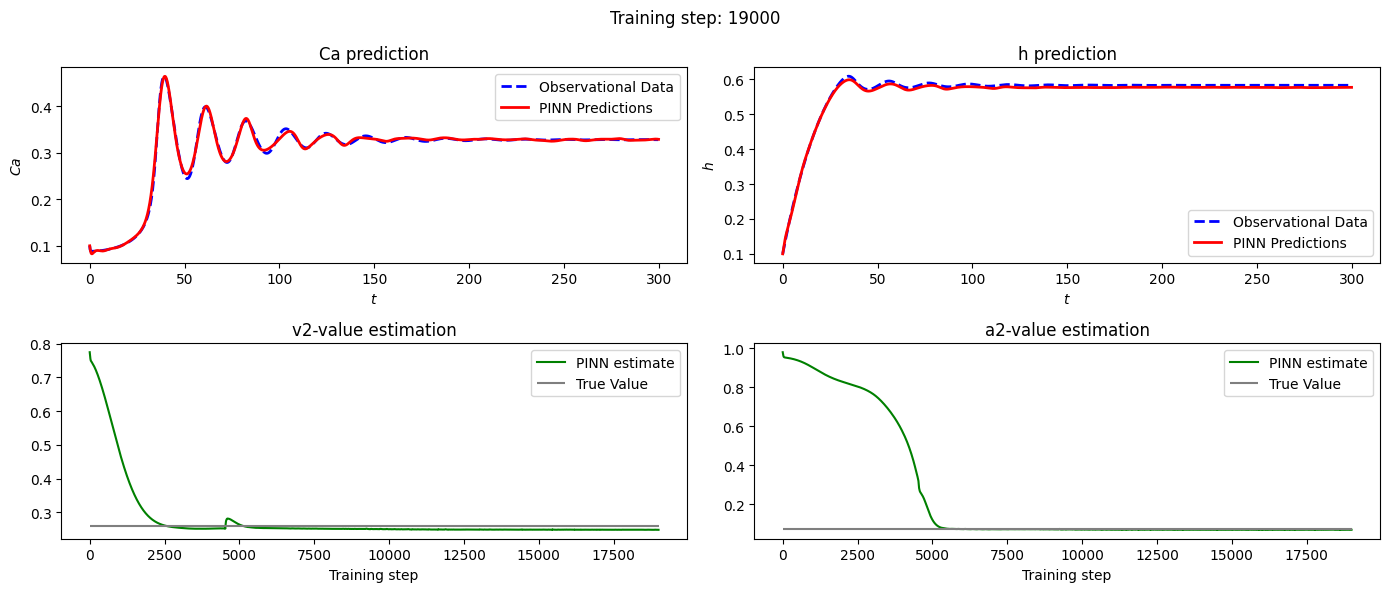

Training step: 20000
Loss = 1.979710987143335e-06 | Physics_loss = 1.5659226846764795e-05| Initial_loss = 0.0 | Data_loss = 4.137882569921203e-05


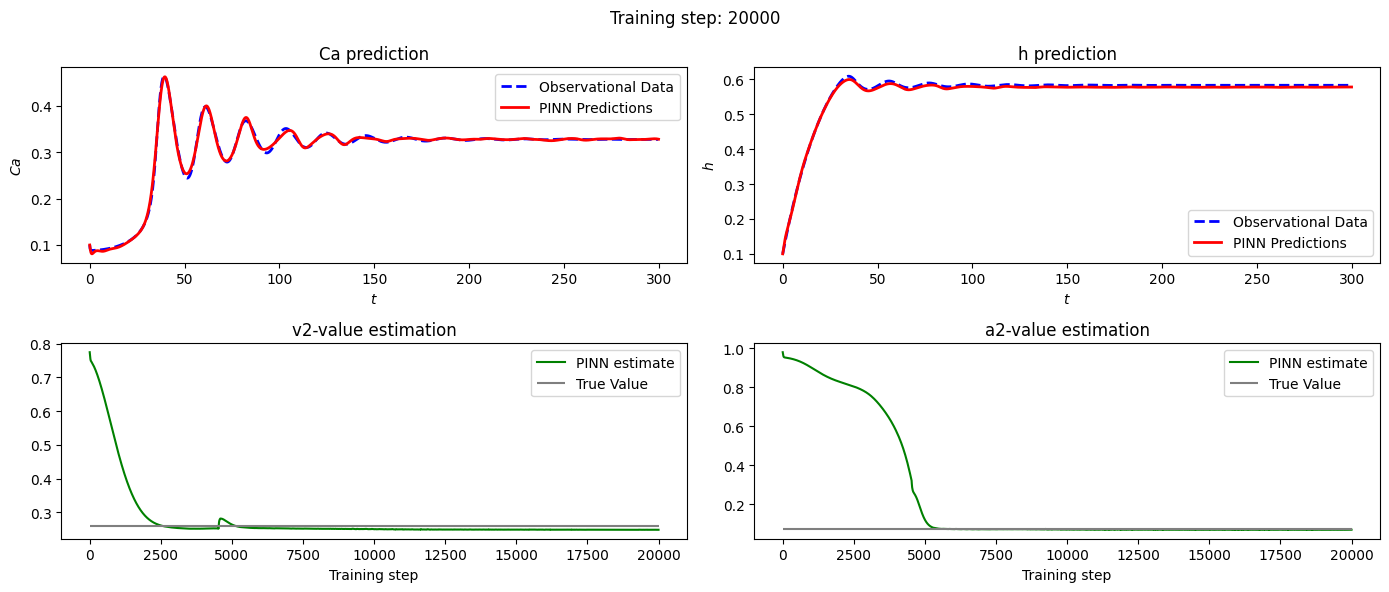

In [161]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 300, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 300, 0.20).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1).to(device)

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.26
#a2 = 0.07

lam1, lam2, lam3 = 1e-2, 1, 1e-1
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  20001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), 'b--', label="Observational Data", linewidth=2)
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), 'r',  label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), 'b--', label="Observational Data", linewidth=2)
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), 'r', label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.26, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.07, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [162]:
v2s[-1], a2s[-1]

(0.24840742349624634, 0.06809811294078827)

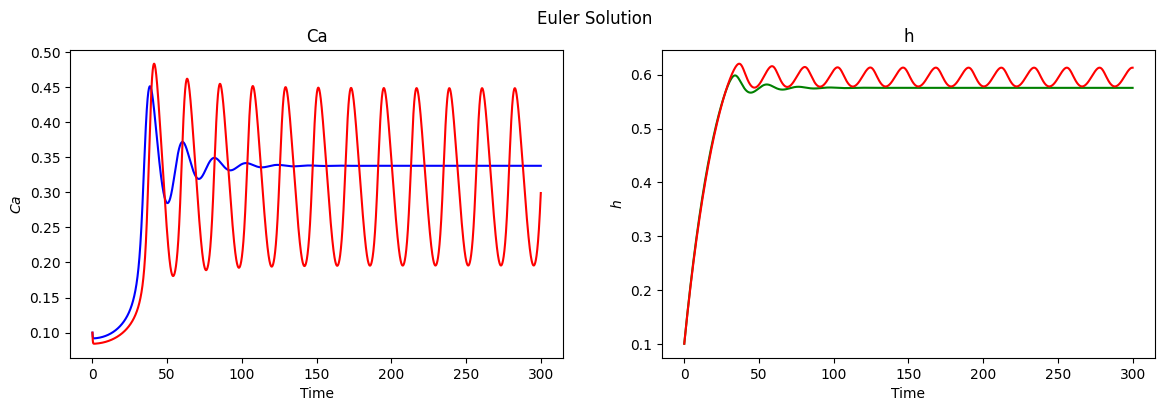

In [163]:
v2 = 0.27
a2 = 0.07
IP3 = 0.5
d5 = 0.10
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 300, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

v2 = v2s[-1]
a2 = a2s[-1]
IP3 = 0.5
d5 = 0.10
k3  = 0.08

Ca_euler2, h_euler2 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.plot(t1, Ca_euler2, 'r')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.plot(t1, h_euler2, 'r')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
df = pd.read_excel("D:\Studies\Semester 3\Applied Mathematics\Python Tutorials\Data\Group6_Data.xlsx")
time, mean = df.to_numpy().T
degree = 2
poly_coeffs = np.polyfit(time, mean, degree)
baseline = np.polyval(poly_coeffs, time)
baseline_corrected_values = mean - baseline
min_value = np.min(baseline_corrected_values)
max_value = np.max(baseline_corrected_values)
normalized_data = (baseline_corrected_values - min_value) / (max_value - min_value)

In [9]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.5
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

Training step: 0
Loss = 0.02450760453939438 | Physics_loss = 2.424415111541748 | Data_loss = 0.026345456019043922


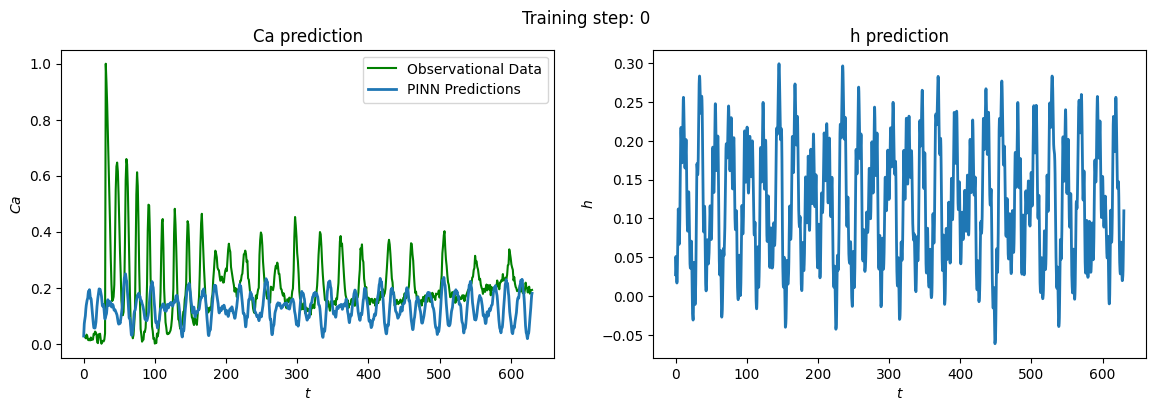

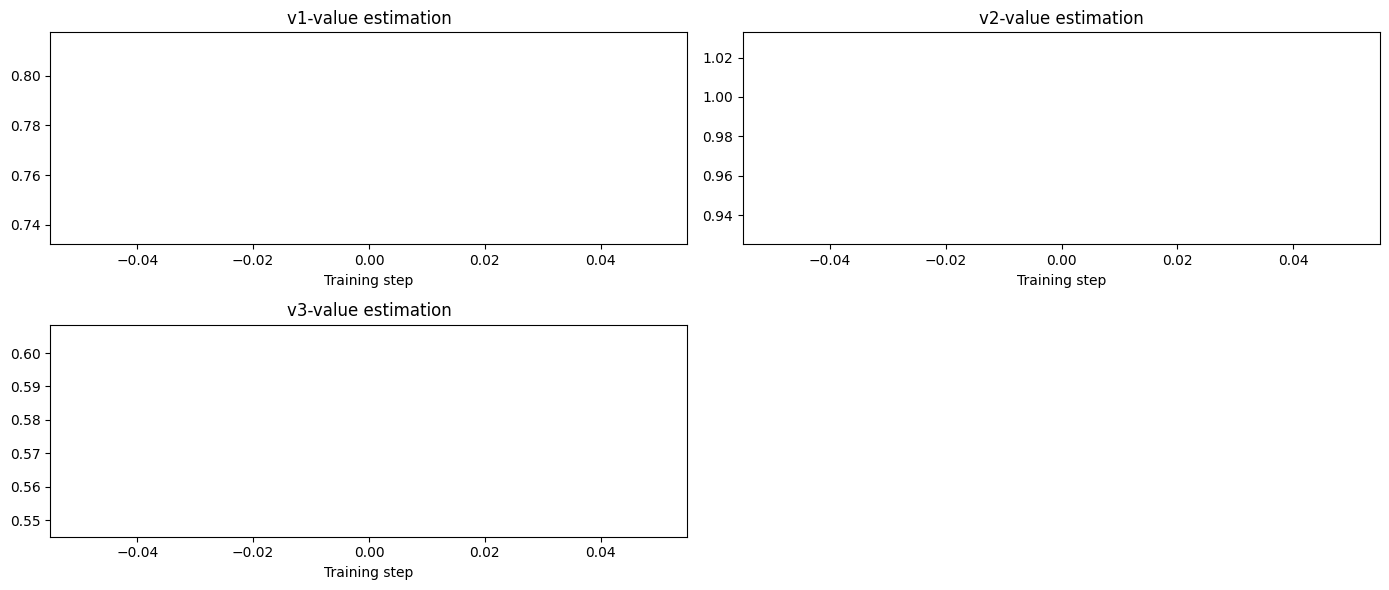

Training step: 100
Loss = 0.004568285308778286 | Physics_loss = 0.1897064745426178 | Data_loss = 0.2671220600605011


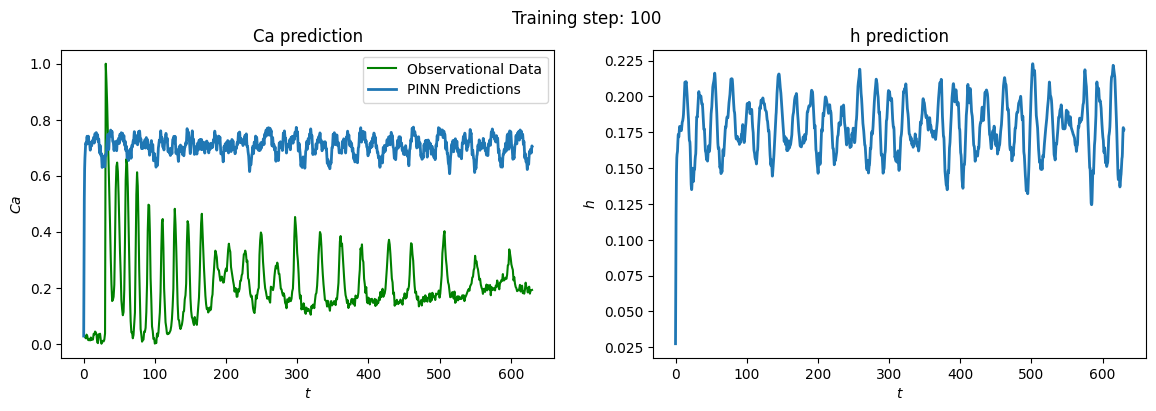

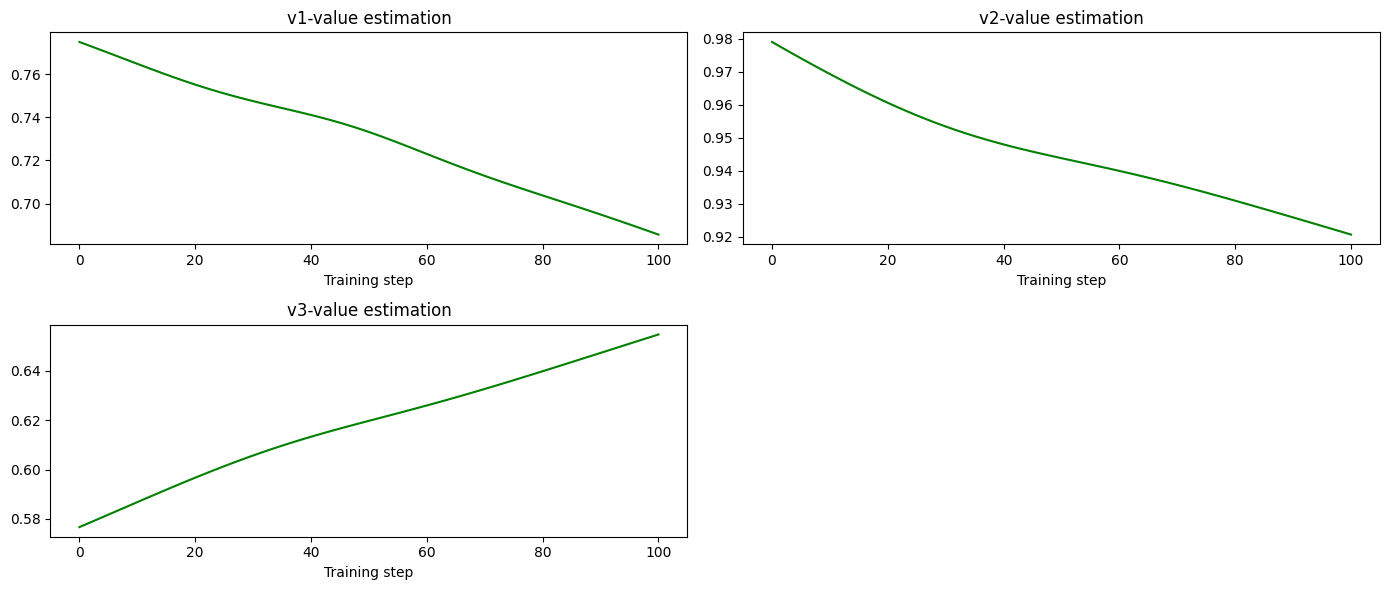

Training step: 200
Loss = 0.0032894331961870193 | Physics_loss = 0.14188918471336365 | Data_loss = 0.18705415725708008


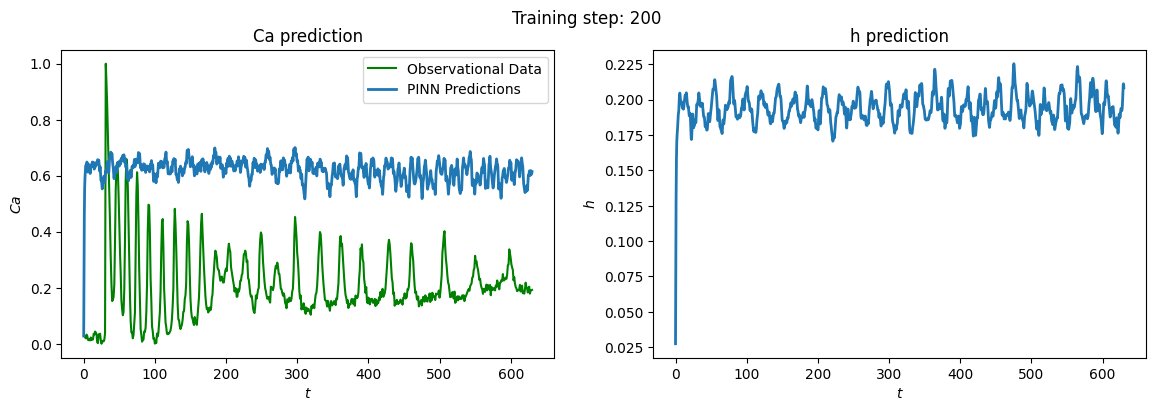

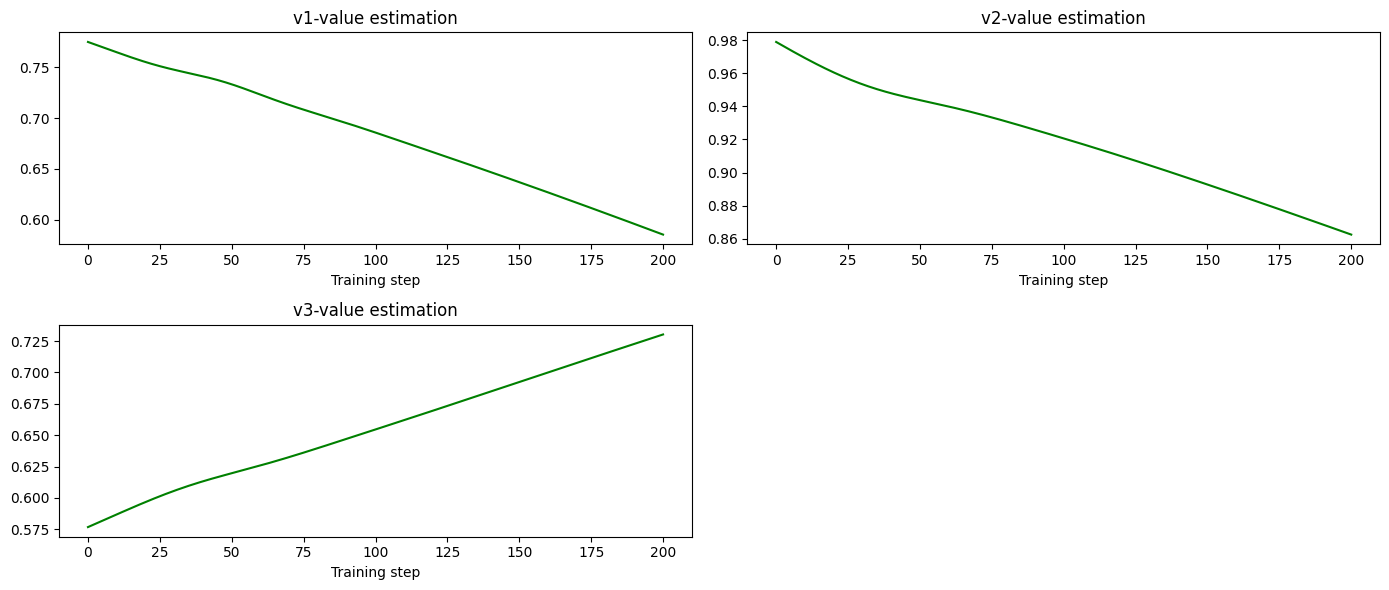

Training step: 300
Loss = 0.0021400763653218746 | Physics_loss = 0.09191089868545532 | Data_loss = 0.12209673970937729


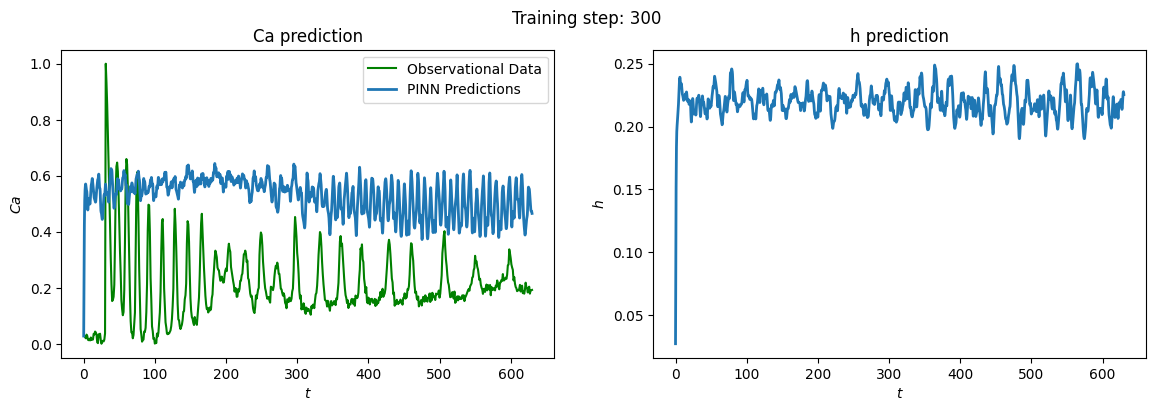

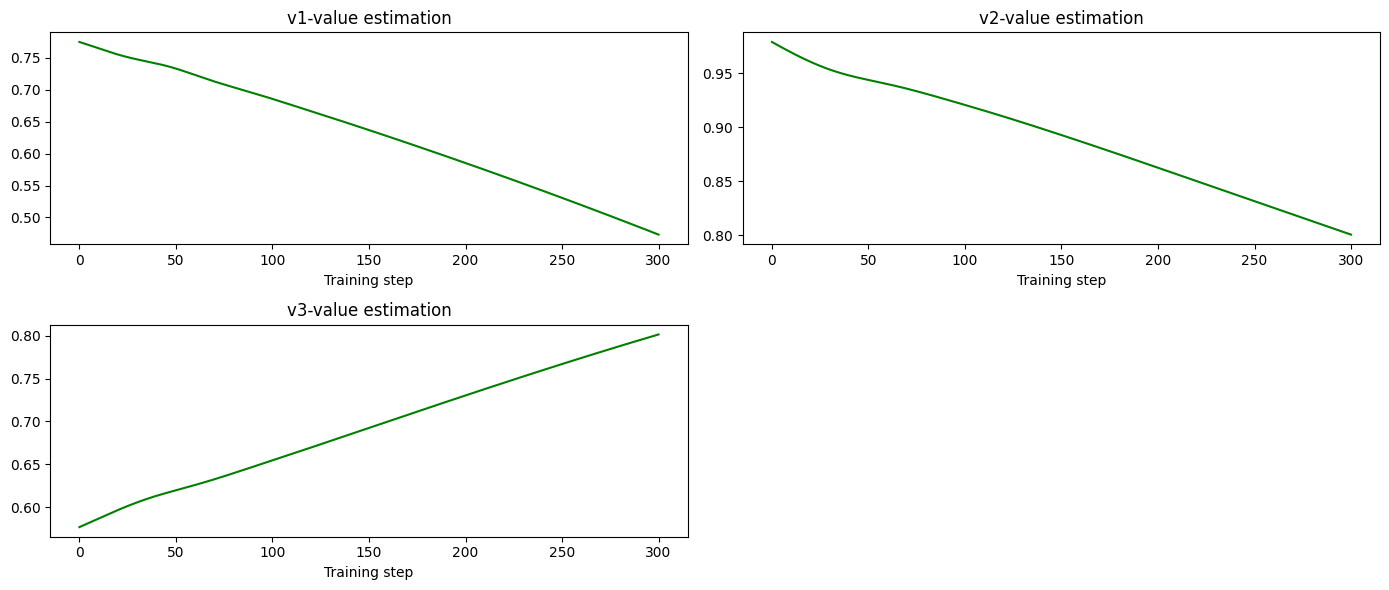

Training step: 400
Loss = 0.0013580787926912308 | Physics_loss = 0.056842826306819916 | Data_loss = 0.07896506041288376


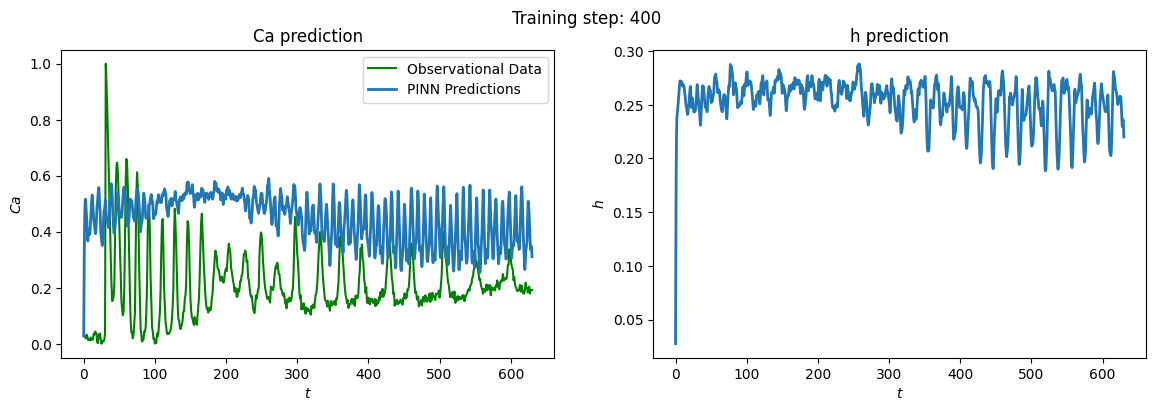

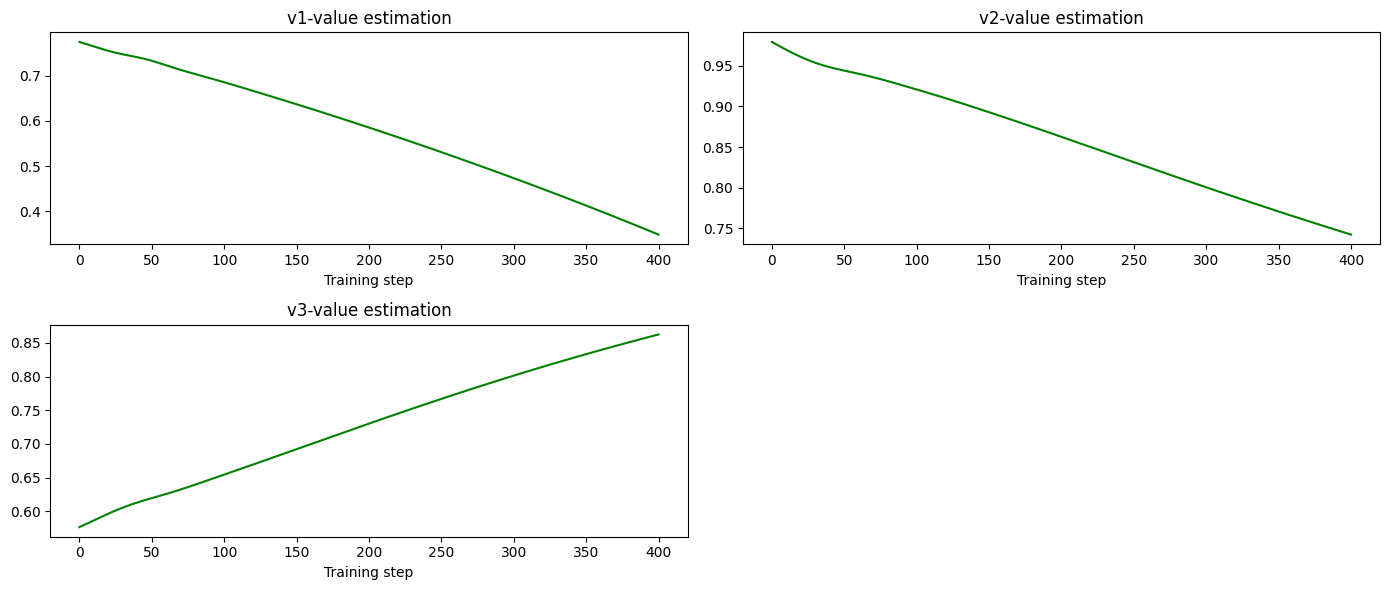

Training step: 500
Loss = 0.000856072292663157 | Physics_loss = 0.033622778952121735 | Data_loss = 0.051984455436468124


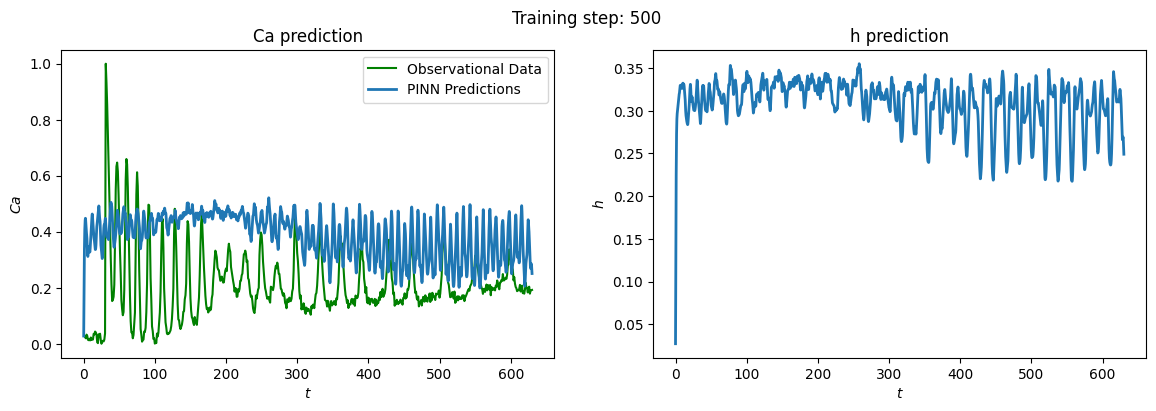

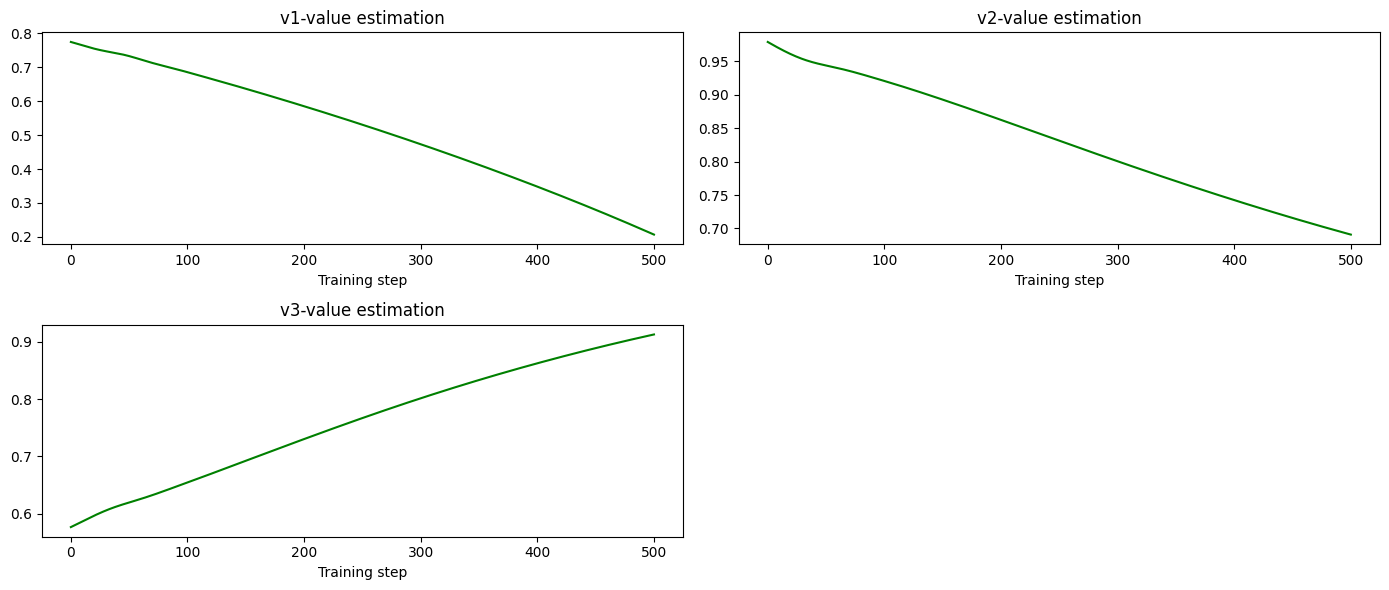

Training step: 600
Loss = 0.0005422708345577121 | Physics_loss = 0.018816400319337845 | Data_loss = 0.03541068732738495


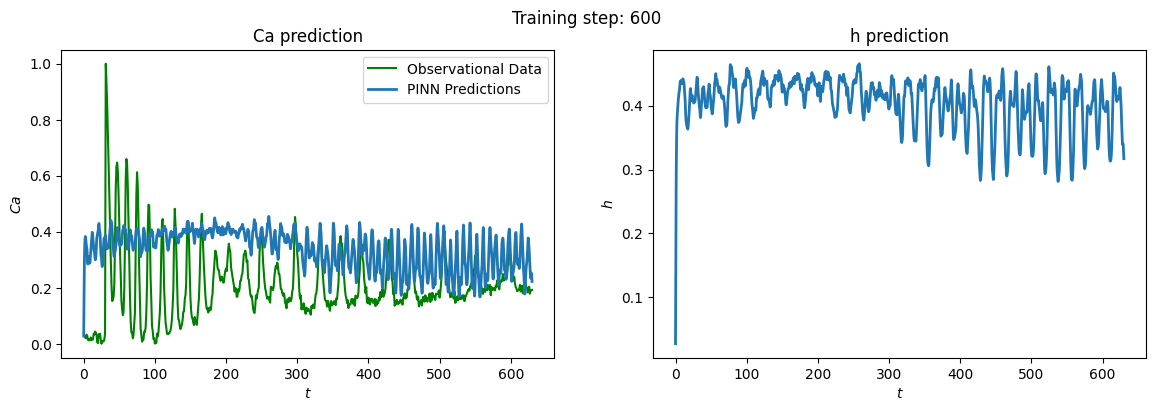

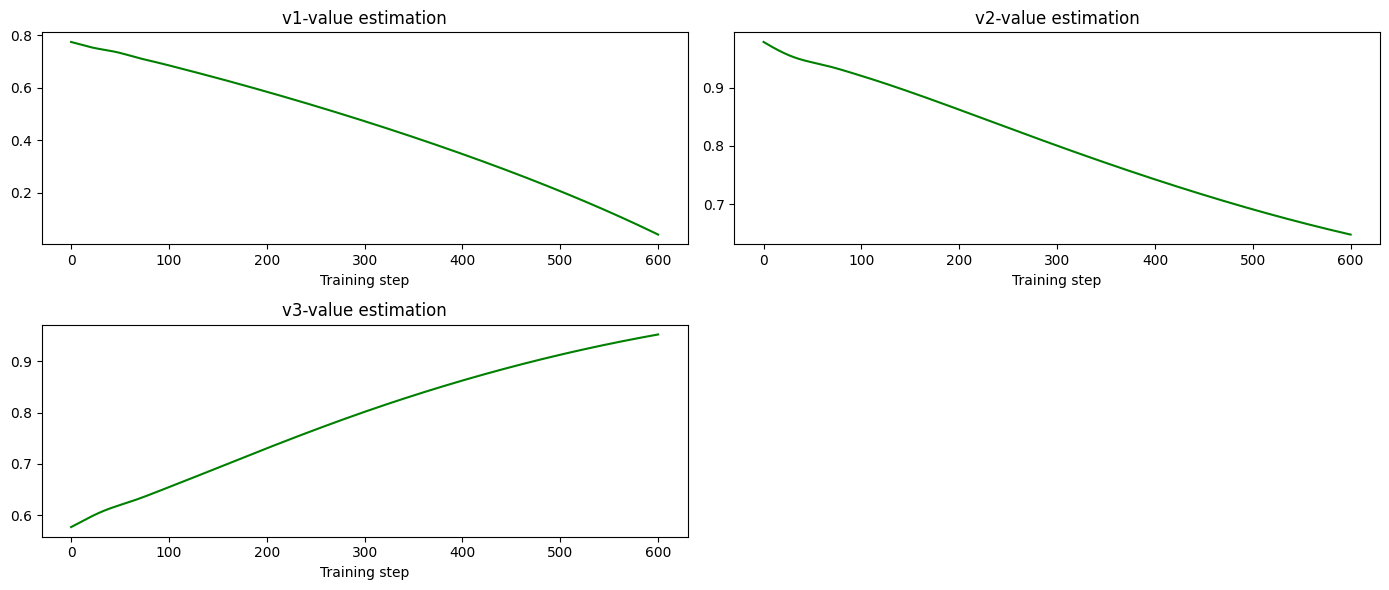

Training step: 700
Loss = 0.00035469894646666944 | Physics_loss = 0.010595794767141342 | Data_loss = 0.02487410232424736


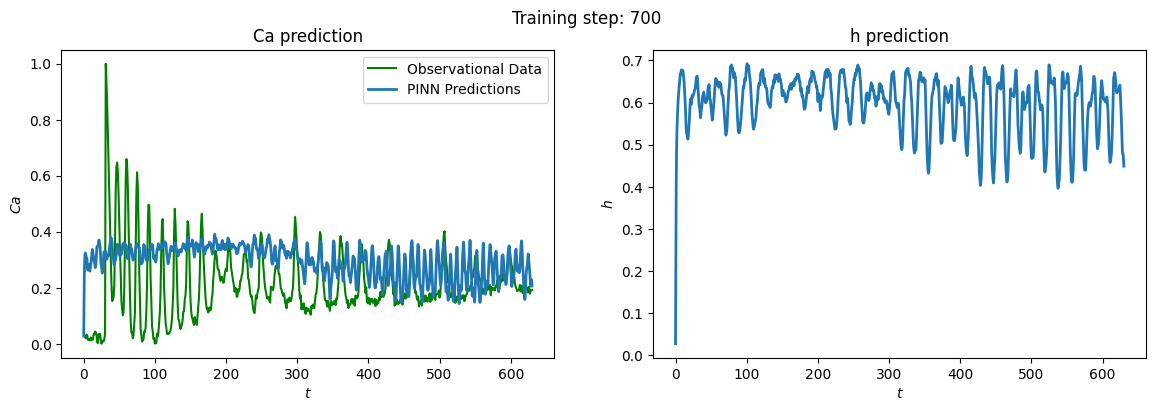

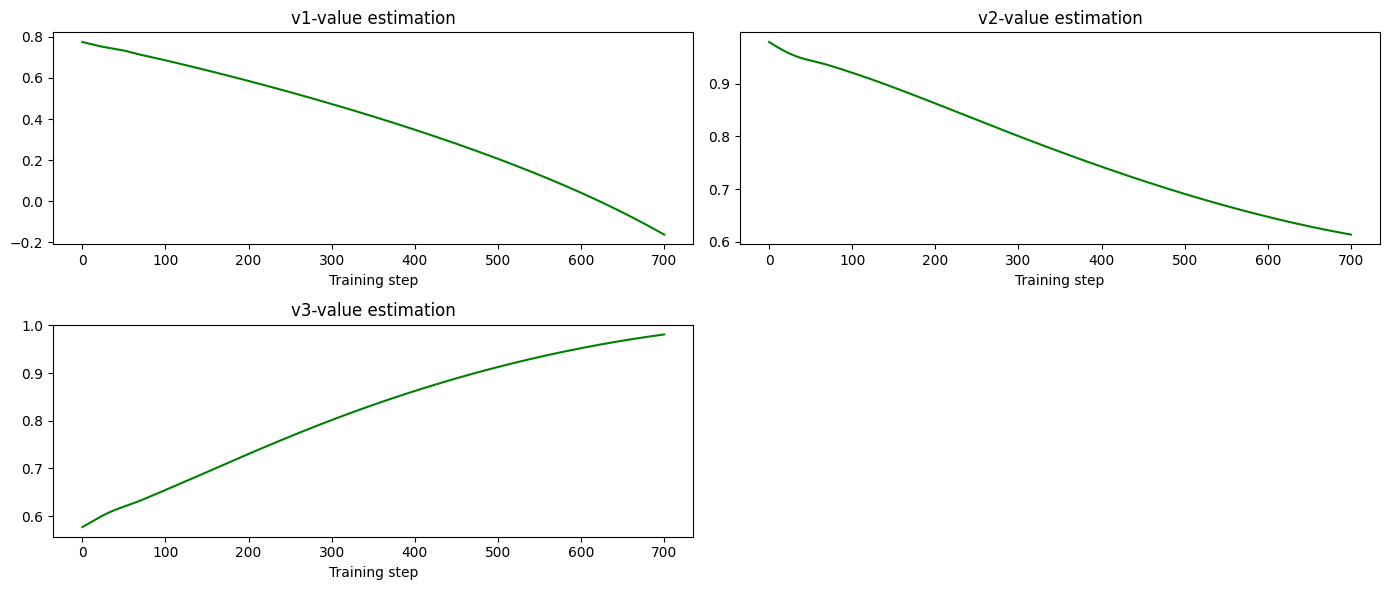

Training step: 800
Loss = 0.0002569810312706977 | Physics_loss = 0.008131476119160652 | Data_loss = 0.017566628754138947


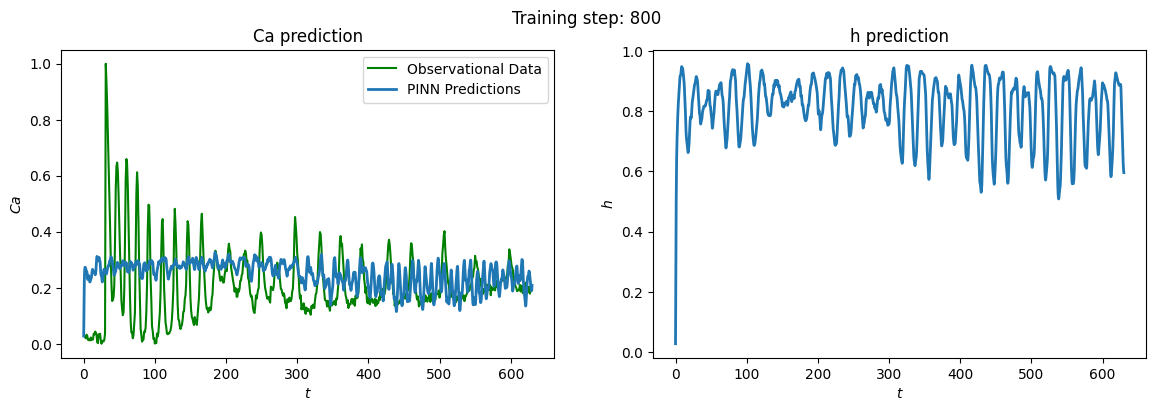

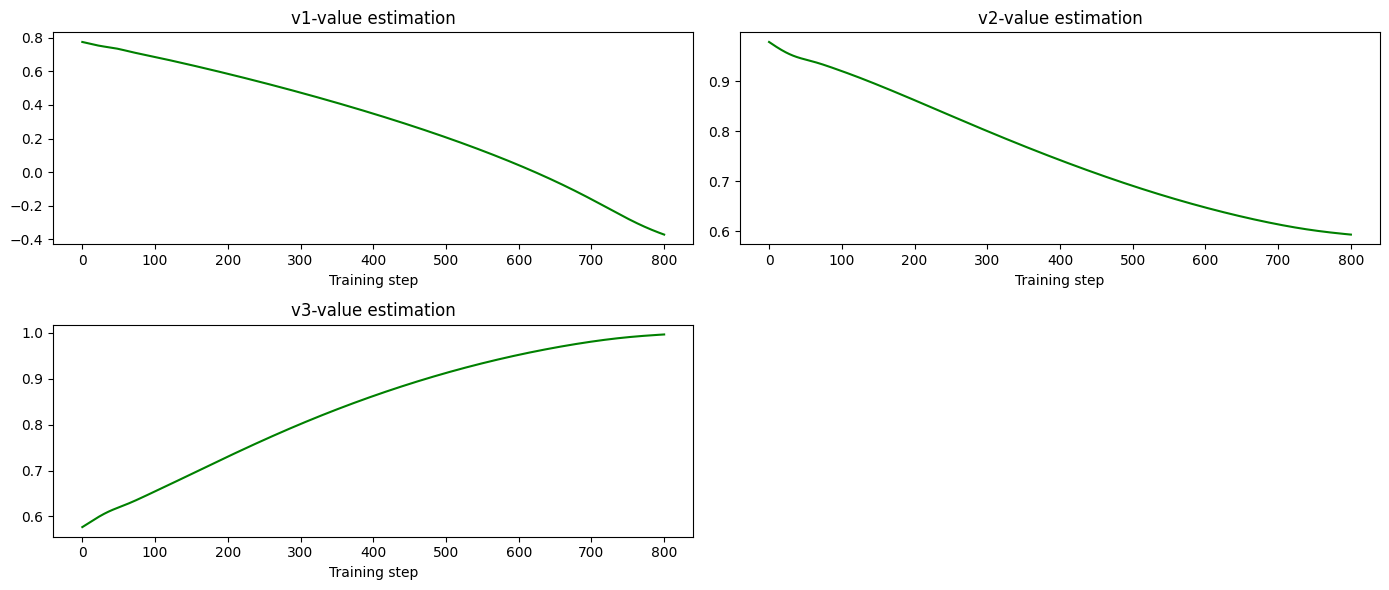

Training step: 900
Loss = 0.00022614894260186702 | Physics_loss = 0.0064120907336473465 | Data_loss = 0.016202803701162338


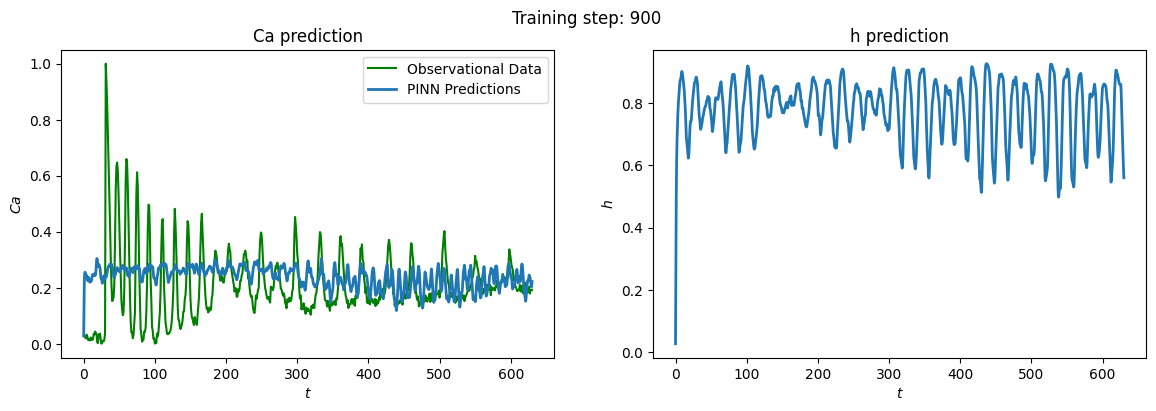

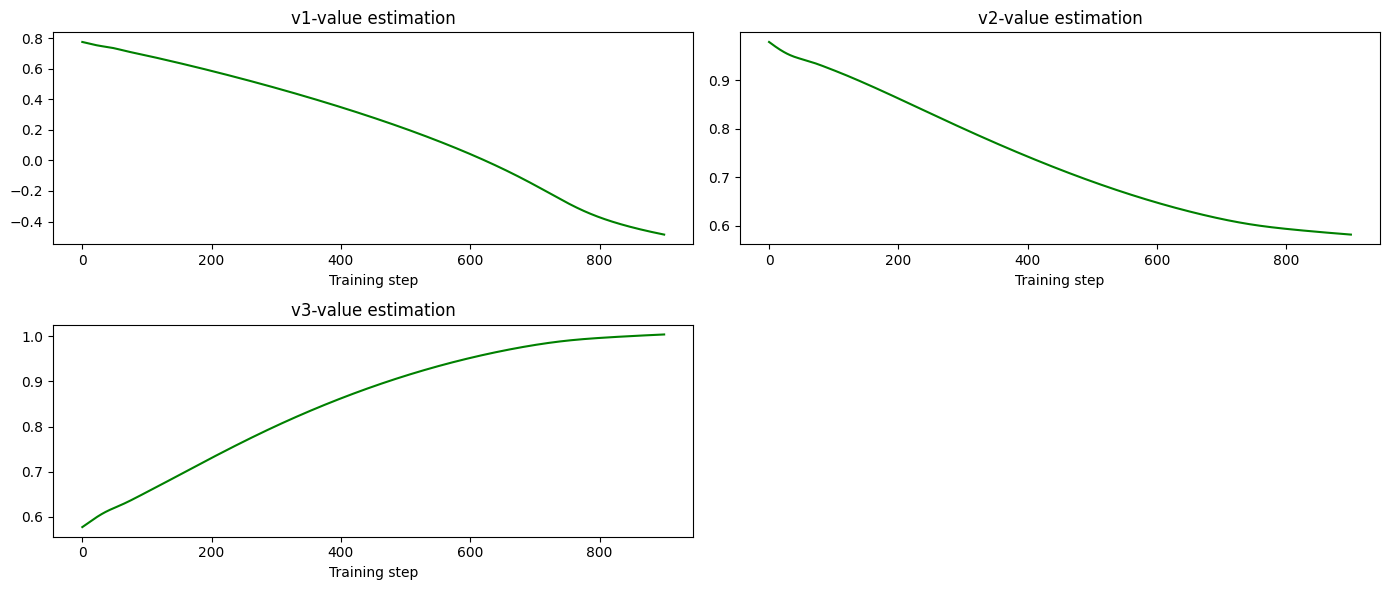

Training step: 1000
Loss = 0.00021043370361439884 | Physics_loss = 0.0054811094887554646 | Data_loss = 0.015562261454761028


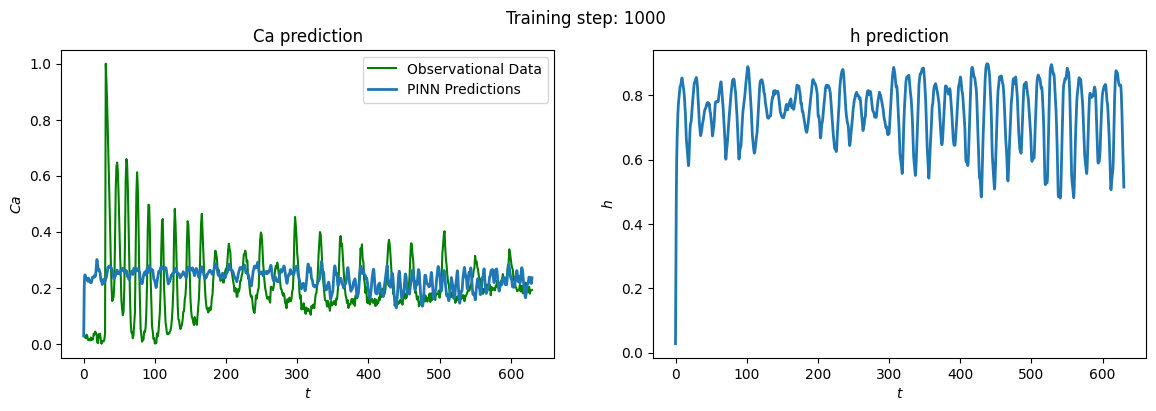

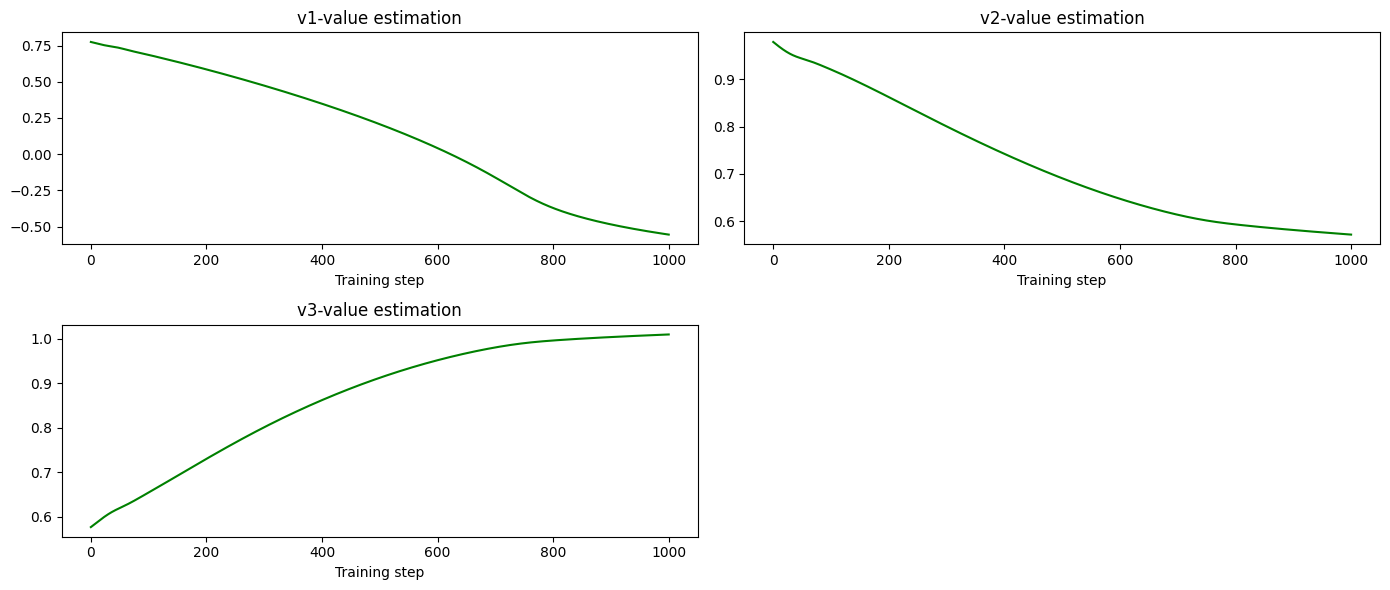

In [10]:
torch.manual_seed(42)

Ca_exp = torch.tensor(normalized_data, dtype=torch.float).view(-1, 1)
t = torch.tensor(time, dtype=torch.float, requires_grad=True).view(-1, 1)
t_test = torch.arange(0, 630, 0.01).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1)

pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([Ca_exp.squeeze()[0], Ca_exp.squeeze()[0]]).view(1,-1))

IP3 = 0.5
c0 = 2
c1 = 0.185
a2 = 0.2
d1 = 0.13
d2 = 1.049
d3 = 0.9434
d5 = 0.08234
k3 = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
# v1, v2, v3

v1 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
v3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2 = 1e-2, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v1, v2, v3], lr=0.001)
epochs =  1001

v1s = []
v2s = []
v3s = []

torch.autograd.set_detect_anomaly(True)

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(t)
    Ca_preds = sol[:, 0].view(-1, 1)
    loss1 = torch.mean((Ca_preds - Ca_exp)**2)

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss2 = torch.mean((res1)**2)
    loss3 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1) + lam2*(loss2 + loss3)
    loss.backward()
    optimiser.step()

    v1s.append(v1.item())
    v2s.append(v2.item())
    v3s.append(v3.item())

    if i % 100 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss2 + loss3} | Data_loss = {loss1}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 4))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(121)
        plt.plot(t.detach().cpu(), Ca_exp.detach().cpu(), 'g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        # plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.show()

        plt.figure(figsize=(14, 6))
        plt.subplot(221)
        plt.plot(v1s, c='green')
        # plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v1-value estimation")
        plt.xlabel("Training step")

        plt.subplot(222)
        plt.plot(v2s, c='green')
        # plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")

        plt.subplot(223)
        plt.plot(v3s, c='green')
        # plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("v3-value estimation")
        plt.xlabel("Training step")
        plt.tight_layout()
        plt.show()
